In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals
from keras import models
from keras import optimizers
from keras import callbacks
from keras.optimizers import Adam
from keras import layers
from keras.utils.vis_utils import plot_model
import keras.backend as K

import tensorflow as tf

import numpy as np
import skimage
import cv2
import scipy.io
import pprint
import glob

import PIL as pillow
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
from matplotlib import pyplot as plt
import matplotlib

from keras.engine.topology import Layer

from mpl_toolkits.mplot3d import Axes3D
from keras.models import load_model

import json



import random
from sklearn.model_selection import train_test_split

# tf.enable_eager_execution()

%matplotlib notebook

Using TensorFlow backend.


In [2]:
# configuration of model

labels_model= ['auto','people','tree','beton','sign']
num_classes = len(labels_model)

IMAGE_H, IMAGE_W, IMAGE_D = 1024, 256, 80
GRID_H,  GRID_W, GRID_D = 16,8,5
BOX              = 5
CLASS            = len(labels_model)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')
# ANCHORS          = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
# anchors_list = [[60,60,40],[50,40,40],[40,40,40], [20,20,40], [10,10,40],[30,30,40]]
# anchors_list = [[40,130,40],[35,90,40],[70,65,40], [65,105,40], [30,65,40],[120,110,40]] #new ones
anchors_list = [[40,120,40],[35,60,40],[205,110,40], [40,100,40], [50,150,40],[75,110,40]] #new new ones
num_boxes = len(anchors_list)

# class_dict_counter = {49.0: 1608, 53.0: 548, 52.0: 73, 51.0: 266, 50.0: 1} #distributu
class_dict = {49.0: 0,50.0: 1,51.0:2, 52.0: 3, 53.0: 4}

BATCH_SIZE       = 1
WARM_UP_BATCHES  = 0
TRUE_BOX_BUFFER  = 50


ALPHA = 0.1

In [3]:
def get_model_test():
    input_image = layers.Input(shape=(IMAGE_H/2,IMAGE_W/2,IMAGE_D/2,1))
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same', name = 'conv_0_1')(input_image)
    x = layers.BatchNormalization(name='norm_0_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(2,2,1))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same',name = 'conv_1_1')(x)
    x = layers.BatchNormalization(name='norm_1_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,4,4))(x)
    
    x = layers.Conv3D(filters = 16,kernel_size=(10,10,10),strides = (1,1,1),padding = 'same')(x)
    x = layers.BatchNormalization(name='norm_5_1')(x)
    x = layers.advanced_activations.LeakyReLU(alpha=ALPHA)(x)
    x = layers.MaxPool3D(pool_size=(4,2,2))(x)
    
    x = layers.Conv3D(filters = (4+1+num_classes)*num_boxes, kernel_size=(1,1,1), strides =(1,1,1), padding = 'same', name= 'yolo')(x)
    output = layers.Reshape((GRID_H,GRID_W,GRID_D,num_boxes, 4+1+num_classes))(x)
    
#     output = layers.Lambda(lambda args: args[0])([output, true_boxes])
    
    model = models.Model(input_image,output)
    return model

In [45]:
# model = Model(inputs = input,outputs = x)
model = get_model_test()
mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


# model_loss = mine_loss()

model.compile(loss=model_loss_3, optimizer=mypotim)

In [14]:
# model.load_weights('warehouse/03.10.19_good_model/weights_good_loader.h5')
model.load_weights('weights_good_loader.h5')

In [4]:
directory_val = os.path.abspath('val_data')
pathname_val = os.listdir(directory_val)
def return_val():
    for file in pathname_val:
        matr = scipy.io.loadmat(os.path.join(directory_val,file))

        frame_data = np.zeros((40,512,128,40,1))
        targets_data = np.zeros((40,20,5))
        y_true_data = np.zeros((40,16,8,5,6,10))
        for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                
                Labels[:,1:5] = Labels[:,1:5]/2
                
                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
        #                 true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
#                     targets = targets/2
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
        #                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

                    frame_data[num_frame,...] = frame
                    targets_data[num_frame,...] = targets[0]
                    y_true_data[num_frame,...] = y_true
    return (frame_data, y_true_data )


In [5]:
pathname = os.path.abspath('data')
def generator_2(pathname = pathname):
    while True:
        for file in random.shuffle(glob.glob(pathname+'/*.mat')):
            matr = scipy.io.loadmat(file)
            for num_frame in range(len(matr['Labels'])):
                Labels = np.array(matr["Labels"][num_frame])
                
                Labels[:,1:5] = Labels[:,1:5]/2
#                 Labels = Labels/2

                object_mask = Labels[:,0]
                if object_mask.shape[0] != 0:
                    true_boxes = Labels[:,:]
                    targets = np.expand_dims(Labels,0)
                    targets = abs(targets)
                    frame = matr["Matr"][num_frame]
                    frame = frame[::2,::2,::2]
                    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                    yield ([frame,targets], y_true )

In [6]:
pathname = os.path.abspath('data')
dir_list = os.listdir(pathname)
full_frame_dir = []

for dir_item in dir_list:
    for num in range(40):
        full_frame_dir.append([os.path.join(pathname,dir_item), num])
#     print(os.path.join(pathname, dir_item))
# print(full_frame_dir[0])

train_list, test_list = train_test_split(full_frame_dir, train_size = 0.96)

def generator_train(train_list = train_list):
    while True:
        random.shuffle(train_list)
        for item in train_list:
            file = item[0]
            num_frame = item[1]
            matr = scipy.io.loadmat(file)
            Labels = np.array(matr["Labels"][num_frame])
#             Labels = Labels/2
            Labels[:,1:5] = Labels[:,1:5]/2
    
            object_mask = Labels[:,0]
            if object_mask.shape[0] != 0:
                true_boxes = Labels[:,:]
                targets = np.expand_dims(Labels,0)
                targets = abs(targets)
                frame = matr["Matr"][num_frame]
                frame = frame[::2,::2,::2]
                frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
                y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))
                yield (frame, y_true )
    
def return_test():
    counter = 0 
    for item in test_list:
        
        file = item[0]
        num_frame = item[1]
        matr = scipy.io.loadmat(file)

        frame_data = np.zeros((len(test_list),512,128,40,1))
        targets_data = np.zeros((len(test_list),20,5))
        y_true_data = np.zeros((len(test_list),16,8,5,6,10))
        Labels = np.array(matr["Labels"][num_frame])
        
        Labels[:,1:5] = Labels[:,1:5]/2
        
        object_mask = Labels[:,0]
        if object_mask.shape[0] != 0:
#                 true_boxes = Labels[:,:]
            targets = np.expand_dims(Labels,0)
#             targets = targets/2
            targets = abs(targets)
            frame = matr["Matr"][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(frame.shape[0],frame.shape[1],frame.shape[2],1))
            y_true = preprocess_true_boxes(targets)
#                 true_boxes = np.reshape(true_boxes,(1,1,1,true_boxes.shape[0],true_boxes.shape[1]))

            frame_data[counter,...] = frame
            targets_data[counter,...] = targets[0]
            y_true_data[counter,...] = y_true
            counter += 1
    return (frame_data, y_true_data )

/home/cognitive-comp/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:
val_loss_arr  = []
loss_arr = []

while True:
    
    H = model.fit_generator(generator_train(full_frame_dir),validation_data= return_val(), steps_per_epoch= 60, epochs = 10)
    
    val_loss_arr.append(H.history['val_loss'])
    
    loss_arr.append(H.history['loss'])
    plt.figure()
    plt.plot(np.ravel(np.array(val_loss_arr)))
    plt.plot(np.ravel(np.array(loss_arr)))
    plt.show()

Epoch 1/10
49/60 [=======================>......] - ETA: 1:29 - loss: 1106.7890

In [83]:
# np.save('val_loss_progress.npy', np.ravel(np.array(val_loss_arr)))
# np.save('loss_progress.npy', np.ravel(np.array(loss_arr)))
# model.save('train_full_train.h5')
# model.save_weights('weights_good_loader.h5')

In [61]:
# json_model  = model.to_json()

In [62]:
# with open('model_arch.json', 'w') as json_file:
#     json.dump(json_model, json_file)

In [10]:
# plt.figure( figsize= (10,10))
# plt.plot(np.ravel(np.array(val_loss_arr)))
# plt.plot(np.ravel(np.array(loss_arr)))
# plt.savefig('results/train_good_loader.png')
# plt.show()

In [7]:
def preprocess_true_boxes(true_boxes , input_shape = (16,8,5), anchors = anchors_list, num_classes = 5 ):
    
    true_boxes = np.array(true_boxes)

    input_shape = (16,8,5)
#     original_input_shape = (1024,256,80)
    original_input_shape = (512,128,40)
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    anchors = np.array(anchors)
    
    input_shape = np.array(input_shape, dtype='int32')
    boxes_xy = np.array(true_boxes[..., 1:3])
    boxes_wh = np.array(true_boxes[..., 3:5])
    
    div_true_boxes_xy = (boxes_xy%(original_input_shape[0:2]/input_shape[0:2]))/(original_input_shape[0:2]/input_shape[0:2])
#     div_true_boxes_xy = boxes_xy
#     div_true_boxes_wh = boxes_wh%(original_input_shape[0:2]/input_shape[0:2])
    div_true_boxes_wh = boxes_wh
    div_true_boxes = np.concatenate((div_true_boxes_xy,div_true_boxes_wh),axis =2)

    true_boxes[..., 1:3] = boxes_xy//(original_input_shape[0:2]/input_shape[0:2][::])
    true_boxes[..., 3:5] = boxes_wh//(original_input_shape[0:2]/input_shape[0:2][::]) #третья координата не добавлена еще

    m = true_boxes.shape[0]
    y_true = np.zeros((m,input_shape[0],input_shape[1],input_shape[2],len(anchors),4+1+num_classes),dtype='float32') 
    anchors = np.expand_dims(anchors, 0)
    anchors = anchors[...,0:2] #здесь изменить потом
    anchor_maxes = anchors / 2.
    anchor_mins = -anchor_maxes
    valid_mask = boxes_wh[..., 0]>0
    
#     print(true_boxes)
#     print(true_boxes.shape)
#     print(true_boxes[0,:,1:3]*(original_input_shape[0:2]/input_shape[0:2]))
#     print(div_true_boxes_xy[0]*(original_input_shape[0:2]/input_shape[0:2]))
#     print((true_boxes[0,:,1:3]+div_true_boxes_xy)*(original_input_shape[0:2]/input_shape[0:2]))
#     print(y_true.shape)
#     print(np.sum(valid_mask))

    for b in range(m):
        
        wh = boxes_wh[b, valid_mask[b]]
#         print(wh)
        if len(wh)==0: continue
        wh = np.expand_dims(wh, -2)
              
        box_maxes = wh / 2.
        box_mins = -box_maxes
        
        intersect_mins = np.maximum(box_mins, anchor_mins)
        intersect_maxes = np.minimum(box_maxes, anchor_maxes)
        
        intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
#         print(intersect_wh.shape, intersect_wh)
        intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area + 1e-4)
#         print(iou.shape, iou)
        best_anchor = np.argmax(iou, axis=-1)
#         print(best_anchor)
        
#         print(true_boxes[0])
        for t, n in enumerate(best_anchor):
            i = true_boxes[b,t,2].astype('int32')
            j = true_boxes[b,t,1].astype('int32')
            l = int(20//(original_input_shape[2]/input_shape[2]))
#             k = n

#             c = 1 #stable version
            
            if true_boxes[b,t,0] in class_dict.keys():
                c = class_dict[true_boxes[b,t,0]]
            else:
                c = 1
#             print(true_boxes[b,t,0], c)
            
            for k in range(len(anchors[0])):
                y_true[b, j, i, l, k, 0:2] = div_true_boxes_xy[b,t,:]
                y_true[b, j, i, l, k, 2:4] = np.log(div_true_boxes_wh[b,t,:]/anchors[0,k]+ 1e-3)
#                 y_true[b, j, i, l, k, 4] = 1*iou[t,k]
                y_true[b, j, i, l, k, 4] = 1
                y_true[b, j, i, l, k, 5+c] = 1
#     print(y_true[0,:,:,2,2,4])
    return y_true

In [270]:
print(targets)
# print(anchors_list)
y_true = preprocess_true_boxes(targets)
new_targets  = decode_netout(y_true,obj_thresh= 0.6)
new_targets[::6]

[[[ 49.         463.64226869  76.52281369  19.08238276  72.75158428]
  [ 53.         464.53675539  13.61058302  16.10076046  29.21989861]
  [ 49.         153.85171103  64.89448669  22.06400507  75.73320659]
  [ 52.         152.06273764   4.06939163  14.90811153  17.29340938]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0.           0.           0.        ]
  [  0.           0.           0. 

[[149.74738311767578,
  9.0118989944458,
  14.948111772537231,
  17.413410544395447,
  0.7310586],
 [150.1329460144043,
  72.2235631942749,
  22.104005813598633,
  75.85320711135864,
  0.7310586],
 [468.04457664489746,
  11.21129322052002,
  16.14076018333435,
  29.339897632598877,
  0.7310586],
 [467.83451652526855,
  74.98010444641113,
  19.122382402420044,
  72.87158489227295,
  0.7310586]]

In [15]:
def loss_mine_tf_2(y_true,y_pred,anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    
    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    ignore_thresh  = 0.5
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
    
    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
    
    
    y_true, true_boxes = y_true
#     print(y_true.shape)
#     y_true = y_true[0]
#     print(y_true.shape)
#     true_boxes = y_true[1]
#     print(true_boxes.shape)
    
#     input_image, y_true, true_boxes, y_pred = x
#     input_image = matr["Matr"][0]

#     true_boxes = matr['Labels'][0]
#     true_boxes = true_boxes.reshape((1,true_boxes.shape[0],true_boxestrue_boxes.shape[1]))
#     y_true = preprocess_true_boxes(true_boxes)
#     y_pred = preprocess_true_boxes(true_boxes)

#     print(y_true.shape, y_pred.shape, input_image.shape)

#     print(y_pred.shape)
#     print(tf.concat([tf.shape(y_pred)[1:4], tf.constant([tf.shape(anchors)[3], -1])], axis=0))

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    
    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
   

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
#     pred_box_xy    = (cell_grid[:grid_h,:grid_w,:grid_d,:,:2] + tf.sigmoid(y_pred[..., :2]))# sigma(t_xy) + c_xy
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)                          # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])


    # change_1
#     true_box_xy    = y_true[..., 0:2] + (cell_grid[:grid_h,:grid_w,:grid_d,:,:2]*(net_factor[...,:2]/grid_factor[...,:2]))  # (sigma(t_xy) + c_xy)
    true_box_xy    = y_true[..., 0:2]
    true_box_wh    = y_true[..., 2:4] # t_wh
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 

#     true_xy = true_boxes[..., 0:2] / grid_factor[...,:2]
#     true_wh = true_boxes[..., 2:4] / net_factor[...,:2]
#      true_wh = true_boxes[..., 2:4] / (net_factor[...,:2]/grid_factor[...,:2])
    true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = tf.expand_dims(pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2]), 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)
    pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)

#     pred_xy = tf.expand_dims(pred_box_xy / grid_factor[...,:2], 4)
#     pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2], 4)

    
    #pred_xy - относительный, надо добавлять еще grid
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)

    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious   = tf.reduce_max(iou_scores, axis=4)        
    conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    true_xy = true_box_xy
    true_wh = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
    #???

    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]

#     pred_xy = pred_box_xy / grid_factor[...,:2]
#     pred_wh = tf.exp(pred_box_wh) * anchors[...,:2] / net_factor[...,:2] 

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)

    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 



    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    # """
    # Compare each true box to all anchor boxes
    # """      

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

#     wh_scale = tf.exp(true_box_wh) * anchors[...,:2] / net_factor[...,:2]
#     wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the smaller the box, the bigger the scale

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#         class_delta = object_mask * (true_box_class - pred_box_class) * self.class_scale
#     class_delta = object_mask * tf.expand_dims(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class), 4) * class_scale

    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
#     loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_conf), 
#                                    tf.reduce_sum(loss_wh), 
#                                    tf.reduce_sum(loss_class)],  message='conf, wh,  class: \t',   summarize=1000)   

    return loss*grid_scale

In [16]:
def mine_loss():
    def yolo_loss(y_true, y_pred):
        return loss_mine_tf_2(y_true, y_pred)
    return yolo_loss

In [17]:
model_loss = mine_loss()

In [24]:
# true_boxes = targets
y_pred = tf.to_float(np.zeros((1,16,8,5,6,10)))
model_loss([y_true,targets], y_pred)

<tf.Tensor: id=1411, shape=(), dtype=float32, numpy=1457.6246>

In [8]:
def loss_3(y_true,y_pred,anchors = anchors_list):
#     anchors = anchors_list

    max_grid_h, max_grid_w , max_grid_d = (16,16,16)

    anchors = tf.cast(anchors, dtype = tf.float32)

    anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])

    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6

    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])

    input_image = tf.cast(np.zeros((512,128,40)), tf.int32)

    # y_true, true_boxes = y_true

    y_true = K.reshape(y_true, tf.shape(y_true[0,...]))

    y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])

    object_mask     = tf.expand_dims(y_true[..., 4], 4)

    grid_h      = tf.shape(y_true)[0]
    grid_w      = tf.shape(y_true)[1]
    grid_d      = tf.shape(y_true)[2]
    grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])

    net_h       = tf.shape(input_image)[0]
    net_w       = tf.shape(input_image)[1] 
    net_d       = tf.shape(input_image)[2]
    net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])


    pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    # pred_box_xy    = y_pred[..., :2]
    pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
    # pred_box_conf  = tf.expand_dims(y_pred[..., 4], 4)    # adjust confidence
    pred_box_class = K.softmax(y_pred[..., 5:])

    true_box_xy    = y_true[..., 0:2] # [0:1]
    true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
    true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    true_box_class = y_true[...,5:]
    true_box_class = tf.argmax(y_true[...,5:],axis= -1)

    conf_delta  = pred_box_conf - 0 




    # # true_xy = true_boxes[..., 0:2] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 2:4] % (net_factor[...,:2]/grid_factor[...,:2])
    # # true_xy = true_boxes[..., 1:3]/ (net_factor[...,:2]/grid_factor[...,:2])
    # # true_wh = true_boxes[..., 3:5]/ (net_factor[...,:2]/grid_factor[...,:2])
    # true_xy = true_boxes[..., 1:3]
    # true_wh = true_boxes[..., 3:5]

    # true_wh_half = true_wh / 2.
    # true_mins    = true_xy - true_wh_half
    # true_maxes   = true_xy + true_wh_half

    # pred_xy = tf.expand_dims((pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2]), 4)
    # pred_wh = tf.expand_dims(tf.exp(pred_box_wh) * anchors[...,:2], 4)
    # # print(pred_xy[:,:,2,4,0,:2])
    # # print(pred_xy.shape)
    # # print()

    # pred_wh_half = pred_wh / 2.
    # pred_mins    = pred_xy - pred_wh_half
    # pred_maxes   = pred_xy + pred_wh_half    

    # intersect_mins  = tf.maximum(pred_mins,  true_mins)
    # intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    # # print(pred_mins.shape, true_mins.shape, intersect_mins.shape)
    # # print(pred_mins[:,:,2,4,0,:], true_mins, intersect_mins[:,:,2,4,:,:])
    # # print()
    # # print(pred_maxes[], true_maxes, intersect_maxes)



    # intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    # intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    # true_areas = true_wh[..., 0] * true_wh[..., 1]
    # pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    # union_areas = pred_areas + true_areas - intersect_areas
    # iou_scores  = tf.truediv(intersect_areas, union_areas)
    # print(iou_scores.shape)

    # best_ious   = tf.reduce_max(iou_scores, axis=4)        
    # conf_delta *= tf.expand_dims(tf.to_float(best_ious < ignore_thresh), 4)

    # # iou_scores = object_mask * tf.expand_dims(tf.reduce_max(iou_scores,4),4)



    # true_xy = true_box_xy 
    # true_wh = tf.exp(true_box_wh) * anchors[...,:2]
    true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    true_wh = tf.exp(true_box_wh) * anchors[...,:2]


    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    # pred_xy = pred_box_xy * (net_factor[...,:2]/grid_factor[...,:2])
    # pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]
    pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]


    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half      

    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
#     print(iou_scores.shape)
    iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
#     print(iou_scores.shape)

    conf_delta *= tf.to_float(iou_scores < ignore_thresh)


    count       = tf.reduce_sum(object_mask)
    count_noobj = tf.reduce_sum(1 - object_mask)
    detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 

    true_box_xy, true_box_wh, xywh_mask = [true_box_xy, true_box_wh, object_mask]

    wh_scale = tf.exp(true_box_wh) * anchors[...,:2]/net_factor[...,:2]
    wh_scale = tf.expand_dims(2 - wh_scale[..., 0] * wh_scale[..., 1], axis=4) # the

    xy_delta    = xywh_mask   * (pred_box_xy-true_box_xy) * wh_scale * xywh_scale
    wh_delta    = xywh_mask   * (pred_box_wh-true_box_wh) * wh_scale * xywh_scale
    conf_delta  = object_mask * (pred_box_conf-true_box_conf) * obj_scale + (1-object_mask) * conf_delta * noobj_scale
    class_delta = object_mask * tf.expand_dims(tf.keras.backend.sparse_categorical_crossentropy(true_box_class, pred_box_class),4)* class_scale


    loss_xy    = tf.reduce_sum(tf.square(xy_delta),       list(range(0,5)))
    loss_wh    = tf.reduce_sum(tf.square(wh_delta),       list(range(0,5)))
    loss_conf  = tf.reduce_sum(tf.square(conf_delta),     list(range(0,5)))
    loss_class = tf.reduce_sum(class_delta,               list(range(0,5)))
    loss = loss_xy+ loss_wh + loss_conf + loss_class

    loss = tf.Print(loss, [grid_h, avg_obj], message='avg_obj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_noobj], message='avg_noobj \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_iou], message='avg_iou \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, avg_cat], message='avg_cat \t\t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall50], message='recall50 \t', summarize=1000)
    loss = tf.Print(loss, [grid_h, recall75], message='recall75 \t', summarize=1000)   
    loss = tf.Print(loss, [grid_h, count], message='count \t', summarize=1000)     
    loss = tf.Print(loss, [grid_h, tf.reduce_sum(loss_xy), 
                                   tf.reduce_sum(loss_wh), 
                                   tf.reduce_sum(loss_conf), 
                                   tf.reduce_sum(loss_class)],  message='loss xy, wh, conf, class: \t',   summarize=1000) 
    return loss*grid_scale

In [9]:
def model_loss():
    def yolo_loss(y_true,y_pred):
        return loss_3(y_true,y_pred)
    return yolo_loss
model_loss_3 = model_loss()

In [10]:
def metrics_numpy(directory = directory_val, anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6
    
    
    
#     anchors = tf.cast(anchors, dtype = tf.float32)
    anchors = np.array(anchors, dtype = np.float32)

#     anchors = tf.reshape(anchors, shape= [1,1,1,anchors.shape[0],3])
    anchors = np.reshape(anchors, newshape= (1,1,1,anchors.shape[0],3))
    
    avg_iou_whole = 0
    recall50_whole = 0
    recall75_whole = 0  
    avg_obj_whole = 0
    avg_noobj_whole = 0
    avg_cat_whole = 0
    true_counter = 0
    
    print('searching in directory{}'.format(directory))
    
    
    for file in glob.glob(os.path.join(directory,'*.mat')):
        
        print('loading {0}'.format(file))
        matr = scipy.io.loadmat(file)
        
        for num_frame in range(len(matr['Matr'])):
            frame = matr['Matr'][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,512,128,40,1))
            targets = abs(matr['Labels'][num_frame])
            targets = targets/2
            targets = np.reshape(targets, newshape=(1, 20,5))
            y_true =  preprocess_true_boxes(targets)

            y_pred = model.predict(frame)



    #         cell_x = tf.cast(tf.reshape(tf.tile(tf.range(max_grid_d), [max_grid_h*max_grid_w]), (max_grid_h, max_grid_w, max_grid_d, 1, 1)),dtype= tf.float32)
    #         cell_y = tf.transpose(cell_x, (1,2,0,3,4))
    #         cell_z = tf.transpose(cell_x, (2,0,1,3,4))
    #         cell_grid = tf.tile(tf.concat([cell_z,cell_y,cell_x], -1), [1,1,1,anchors.shape[3],1])
            cell_x = np.reshape(np.tile(np.arange(max_grid_d), max_grid_h*max_grid_w), (max_grid_h, max_grid_d, max_grid_w, 1, 1))
            cell_y = np.transpose(cell_x, (1,2,0,3,4))
            cell_z = np.transpose(cell_x, (2,0,1,3,4))
            cell_grid = np.tile(np.concatenate((cell_z,cell_y,cell_x),-1), (1,1,1,6,1))

    #         input_image = tf.cast(np.zeros((512,128,40)), tf.int32)
            input_image = np.zeros((512,128,40))

    #         y_true = K.reshape(y_true, tf.shape(y_true[0,...]))
            y_true = y_true[0]

    #         y_pred = tf.reshape(y_pred, tf.shape(y_pred)[1:])
            y_pred = y_pred[0]

    #         object_mask     = tf.expand_dims(y_true[..., 4], 4)
            object_mask = np.expand_dims(y_true[..., 4], 4)

    #         grid_h      = tf.shape(y_true)[0]
    #         grid_w      = tf.shape(y_true)[1]
    #         grid_d      = tf.shape(y_true)[2]
    #         grid_factor = tf.reshape(tf.cast([grid_h, grid_w, grid_d], tf.float32), [1,1,1,1,3])
            grid_h = y_true.shape[0]
            grid_w = y_true.shape[1]
            grid_d = y_true.shape[2]
            grid_fractor = np.reshape([grid_h, grid_w,grid_d], (1,1,1,1,3))


    #         net_h       = tf.shape(input_image)[0]
    #         net_w       = tf.shape(input_image)[1] 
    #         net_d       = tf.shape(input_image)[2]
    #         net_factor  = tf.reshape(tf.cast([net_h, net_w, net_d], tf.float32), [1,1,1,1,3])
            net_h = input_image.shape[0]
            net_w = input_image.shape[1]
            net_d = input_image.shape[2]
            net_factor = np.reshape([net_h, net_w,net_d], (1,1,1,1,3))


    #         pred_box_xy    = tf.sigmoid(y_pred[..., :2])
    #         pred_box_wh    = y_pred[..., 2:4]                                                       # t_wh
    #         pred_box_conf  = tf.expand_dims(tf.sigmoid(y_pred[..., 4]), 4)    
    #         pred_box_class = K.softmax(y_pred[..., 5:])
            pred_box_xy = 1/(1 + np.exp(-y_pred[...,:2]))
            pred_box_wh = y_pred[...,2:4]
            pred_box_conf = np.expand_dims(1/(1 + np.exp(-y_pred[...,4])), 4)
            pred_box_class = np.exp(y_pred[...,5:])/np.expand_dims(np.sum(np.exp(y_pred[...,5:]),axis= -1), -1)


    #         true_box_xy    = y_true[..., 0:2] # [0:1]
    #         true_box_wh    = y_true[..., 2:4] # t_wh - log(wh/anchors)
    #         true_box_conf  = tf.expand_dims(y_true[..., 4], 4)
    #         true_box_class = y_true[...,5:]
    #         true_box_class = tf.argmax(y_true[...,5:],axis= -1)
            true_box_xy = y_true[...,0:2]
            true_box_wh = y_true[...,2:4]
            true_box_conf = y_true[...,4]
            true_box_class = np.argmax(y_true[...,5:], axis= -1)


            conf_delta  = pred_box_conf - 0 

    #         true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    #         true_wh = tf.exp(true_box_wh) * anchors[...,:2]
            true_xy = (true_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
            true_wh = np.exp(true_box_wh) * anchors[...,:2]


            true_wh_half = true_wh / 2.
            true_mins    = true_xy - true_wh_half
            true_maxes   = true_xy + true_wh_half

    #         pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
    #         pred_wh = tf.exp(pred_box_wh) * anchors[...,:2]
            pred_xy = (pred_box_xy + cell_grid[:grid_h,:grid_w,:grid_d,:,:2]) * (net_factor[...,:2]/grid_factor[...,:2])
            pred_wh = np.exp(pred_box_wh) * anchors[...,:2]

            pred_wh_half = pred_wh / 2.
            pred_mins    = pred_xy - pred_wh_half
            pred_maxes   = pred_xy + pred_wh_half      

    #         intersect_mins  = tf.maximum(pred_mins,  true_mins)
    #         intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    #         intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    #         intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
            intersect_mins  = np.maximum(pred_mins,  true_mins)
            intersect_maxes = np.minimum(pred_maxes, true_maxes)
            intersect_wh    = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

            true_areas = true_wh[..., 0] * true_wh[..., 1]
            pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    #         union_areas = pred_areas + true_areas - intersect_areas
    #         iou_scores  = tf.truediv(intersect_areas, union_areas)
    #         iou_scores  = object_mask * tf.expand_dims(iou_scores, 4)
            union_areas = pred_areas + true_areas - intersect_areas
            iou_scores  = intersect_areas/ union_areas
            iou_scores  = object_mask * np.expand_dims(iou_scores, 4)


    #         conf_delta *= tf.to_float(iou_scores < ignore_thresh)
            conf_delta *= np.array(iou_scores < ignore_thresh,dtype = np.float)


    #         count       = tf.reduce_sum(object_mask)
    #         count_noobj = tf.reduce_sum(1 - object_mask)
    #         detect_mask = tf.to_float((pred_box_conf*object_mask) >= 0.5)
    #         class_mask  = tf.expand_dims(tf.to_float(tf.equal(tf.argmax(pred_box_class, -1), true_box_class)), 4)
    #         recall50    = tf.reduce_sum(tf.to_float(iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
    #         recall75    = tf.reduce_sum(tf.to_float(iou_scores >= 0.75) * detect_mask  * class_mask) / (count + 1e-3)    
    #         avg_iou     = tf.reduce_sum(iou_scores) / (count + 1e-3)
    #         avg_obj     = tf.reduce_sum(pred_box_conf  * object_mask)  / (count + 1e-3)
    #         avg_noobj   = tf.reduce_sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
    #         avg_cat     = tf.reduce_sum(object_mask * class_mask) / (count + 1e-3) 
            count       = np.sum(object_mask)
            count_noobj = np.sum(1 - object_mask)
            detect_mask = ((pred_box_conf*object_mask) >= 0.5).astype(np.float)
            class_mask  = np.expand_dims((np.argmax(pred_box_class, -1) == true_box_class).astype(np.float), 4)
            recall50    = np.sum((iou_scores >= 0.5 ) * detect_mask  * class_mask) / (count + 1e-3)
            recall75    = np.sum((iou_scores >= 0.75).astype(np.float) * detect_mask  * class_mask) / (count + 1e-3)    
            avg_iou     = np.sum(iou_scores) / (count + 1e-3)
            avg_obj     = np.sum(pred_box_conf  * object_mask)  / (count + 1e-3)
            avg_noobj   = np.sum(pred_box_conf  * (1-object_mask))  / (count_noobj + 1e-3)
            avg_cat     = np.sum(object_mask * class_mask) / (count + 1e-3) 
    #         print(count, count_noobj, recall50, recall75)

            avg_iou_whole += avg_iou
            recall50_whole += recall50
            recall75_whole += recall75
            avg_obj_whole += avg_obj
            avg_noobj_whole += avg_noobj
            avg_cat_whole += avg_cat
            true_counter += 1

    print('avg_iou {0}'.format(avg_iou_whole/true_counter))
    print('recall50 {0}'.format(recall50_whole/true_counter))
    print('recall75 {0}'.format(recall75_whole/true_counter))
    print('avg_obj {0}'.format(avg_obj_whole/true_counter))
    print('avg_noobj {0}'.format(avg_noobj_whole/true_counter))
    print('avg_cat {0}'.format(avg_cat_whole/true_counter))

In [215]:
directory_train = os.path.abspath('data')
metrics_numpy(directory_train)

searching in directory/home/cognitive-comp/Рабочий стол/projects/yolo/data
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_23.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_27.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_21.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_10.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_8.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_18.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_6.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_22.mat
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-

In [11]:
def metrics_numpy_targets(directory = directory_val, anchors = anchors_list):
    
    max_grid_h, max_grid_w , max_grid_d = (16,16,16)
    ignore_thresh  = 0.4
    warmup_batches = 1
    grid_scale     = 1
    obj_scale      = 5
    noobj_scale    = 1
    xywh_scale     = 1
    class_scale    = 1
    obj_thresh = 0.6
    
    
    anchors = np.array(anchors, dtype = np.float32)

    anchors = np.reshape(anchors, newshape= (1,1,1,anchors.shape[0],3))
    
    avg_iou_whole = 0
    recall50_whole = 0
    precision_whole = 0
    true_counter = 0
    
    print('searching in directory{}'.format(directory))
    
    
    for file in glob.glob(os.path.join(directory,'*.mat')):
        
        print('loading {0}'.format(file))
        matr = scipy.io.loadmat(file)
        
        for num_frame in range(0,len(matr['Matr'])):
            frame = matr['Matr'][num_frame]
            frame = frame[::2,::2,::2]
            frame = np.reshape(frame,(1,512,128,40,1))
            targets = abs(matr['Labels'][num_frame])
            targets = targets/2
            targets = np.reshape(targets, newshape=(1, 20,5))
            y_true =  preprocess_true_boxes(targets)

            y_pred = model.predict(frame)
            
            predicted_boxes = decode_netout(y_pred, obj_thresh= 0.5)
                     
#             visualise_bird_view(frame,targets, predicted_boxes)
            
            targets = targets[targets[...,0] > 0]
#             print('targets', targets)
#             print('predicts', predicted_boxes[0])
            
            
            if (len(predicted_boxes) != 0) and (targets.shape[0] != 0):
                
                print('before NMS:', len(predicted_boxes))
                predicted_boxes = do_nms_exp(predicted_boxes, 0.5)
                print('after NMS:', len(predicted_boxes))
                
                matric_iou = np.zeros((len(predicted_boxes),len(targets)))

                for i in range(len(predicted_boxes)):
                    box_1 = predicted_boxes[i][0:4]
                    for j in range(len(targets)):

                        box_2 = targets[j][1:]
                        matric_iou[i,j] = bbox_iou_exp(box_1, box_2)

                iou_vector = np.max(matric_iou, axis = 1)
                iou_rows = np.max(matric_iou, axis = 0)
                avg_iou = np.sum(iou_vector)/len(iou_vector)

                print('avg_iou:', avg_iou)

                indeces_TP = iou_vector > 0.5
                indeces_FN = iou_rows < 0.5
                TP_count = np.sum(indeces_TP)
                FP_count = np.sum(np.invert(indeces_TP))
                FN_count = np.sum(indeces_FN)

                precision = TP_count / (TP_count + FP_count)
                recall_50 = TP_count / (TP_count + FN_count)
                
                print('precision: {0} , recall50: {1}'.format(precision, recall_50))
                print('counts', TP_count, FP_count, iou_vector.shape)
                print('iou_vector+ indeces:',iou_vector[iou_vector > 0.5],iou_vector > 0.5)
                print()
            else:
                avg_iou = 0
                recall_50 = 0
                precision = 0
#                 true_counter = 0
                

            avg_iou_whole += avg_iou
            recall50_whole += recall_50
            precision_whole += precision
            true_counter += len(predicted_boxes)
            

    print('avg_iou {0}'.format(avg_iou_whole/true_counter))
    print('avg_precision {0}'.format(precision_whole/true_counter))
    print('recall50 {0}'.format(recall50_whole/true_counter))
    print('true_counter: {0}'.format(true_counter))

In [149]:
metrics_numpy_targets(pathname)

searching in directory/home/cognitive-comp/Рабочий стол/projects/yolo/data
loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_12.mat


/home/cognitive-comp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


before NMS: 30
after NMS: 4
avg_iou: 0.443310511299563
precision: 0.25 , recall50: 0.25
counts 1 3 (4,)
iou_vector+ indeces: [0.83827621] [ True False False False]

before NMS: 30
after NMS: 4
avg_iou: 0.5929350088848465
precision: 0.75 , recall50: 0.75
counts 3 1 (4,)
iou_vector+ indeces: [0.77047666 0.68280961 0.58975109] [ True False  True  True]

before NMS: 48
after NMS: 7
avg_iou: 0.4258457700277204
precision: 0.42857142857142855 , recall50: 0.6
counts 3 4 (7,)
iou_vector+ indeces: [0.52033292 0.61674457 0.8173058 ] [ True  True False False False False  True]

before NMS: 30
after NMS: 4
avg_iou: 0.5347209003038295
precision: 0.75 , recall50: 0.5
counts 3 1 (4,)
iou_vector+ indeces: [0.60422672 0.53259101 0.72429885] [ True  True False  True]

before NMS: 24
after NMS: 4
avg_iou: 0.4780189011207821
precision: 0.5 , recall50: 0.2857142857142857
counts 2 2 (4,)
iou_vector+ indeces: [0.59799174 0.52612111] [False False  True  True]

before NMS: 18
after NMS: 3
avg_iou: 0.49973842333

before NMS: 48
after NMS: 7
avg_iou: 0.4094584125933622
precision: 0.42857142857142855 , recall50: 0.75
counts 3 4 (7,)
iou_vector+ indeces: [0.63220623 0.59524267 0.80130015] [False  True  True False  True False False]

before NMS: 42
after NMS: 5
avg_iou: 0.4054037127738573
precision: 0.6 , recall50: 1.0
counts 3 2 (5,)
iou_vector+ indeces: [0.70832167 0.5488236  0.76987329] [False False  True  True  True]

before NMS: 36
after NMS: 5
avg_iou: 0.41114477438007296
precision: 0.4 , recall50: 0.5
counts 2 3 (5,)
iou_vector+ indeces: [0.53332083 0.54542473] [False  True False False  True]

before NMS: 36
after NMS: 5
avg_iou: 0.4171575709833116
precision: 0.2 , recall50: 0.25
counts 1 4 (5,)
iou_vector+ indeces: [0.79490141] [False False False  True False]

before NMS: 66
after NMS: 11
avg_iou: 0.2642833055990312
precision: 0.2727272727272727 , recall50: 1.0
counts 3 8 (11,)
iou_vector+ indeces: [0.75774583 0.7444278  0.54105466] [False False  True False False False False False False  Tr

before NMS: 60
after NMS: 8
avg_iou: 0.3753764723444323
precision: 0.375 , recall50: 0.6
counts 3 5 (8,)
iou_vector+ indeces: [0.54371406 0.57823256 0.6800367 ] [False  True False  True  True False False False]

before NMS: 48
after NMS: 7
avg_iou: 0.18806872442868552
precision: 0.0 , recall50: 0.0
counts 0 7 (7,)
iou_vector+ indeces: [] [False False False False False False False]

before NMS: 30
after NMS: 5
avg_iou: 0.3433495285168492
precision: 0.4 , recall50: 0.6666666666666666
counts 2 3 (5,)
iou_vector+ indeces: [0.50567614 0.58377419] [False False False  True  True]

before NMS: 36
after NMS: 6
avg_iou: 0.307256364326619
precision: 0.3333333333333333 , recall50: 0.6666666666666666
counts 2 4 (6,)
iou_vector+ indeces: [0.73651447 0.8807328 ] [ True False False False False  True]

before NMS: 24
after NMS: 4
avg_iou: 0.3014480556909549
precision: 0.5 , recall50: 0.6666666666666666
counts 2 2 (4,)
iou_vector+ indeces: [0.53442248 0.50423844] [ True False False  True]

before NMS: 2

before NMS: 12
after NMS: 2
avg_iou: 0.3365865702833051
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 18
after NMS: 2
avg_iou: 0.4041836750964866
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 18
after NMS: 2
avg_iou: 0.35612151973172623
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 12
after NMS: 1
avg_iou: 0.2537627879573019
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 1
avg_iou: 0.4551229931540133
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 1
avg_iou: 0.23296627588039856
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 1
avg_iou: 0.2338289066858312
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 1


before NMS: 24
after NMS: 3
avg_iou: 0.3995265861975937
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 18
after NMS: 2
avg_iou: 0.43483769387321364
precision: 0.5 , recall50: 0.3333333333333333
counts 1 1 (2,)
iou_vector+ indeces: [0.50613652] [ True False]

before NMS: 24
after NMS: 3
avg_iou: 0.5875606709337136
precision: 0.6666666666666666 , recall50: 0.5
counts 2 1 (3,)
iou_vector+ indeces: [0.57032908 0.72045231] [ True False  True]

before NMS: 24
after NMS: 4
avg_iou: 0.38926877473946897
precision: 0.0 , recall50: 0.0
counts 0 4 (4,)
iou_vector+ indeces: [] [False False False False]

before NMS: 24
after NMS: 3
avg_iou: 0.34676030732038776
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 24
after NMS: 3
avg_iou: 0.569072601921782
precision: 0.6666666666666666 , recall50: 0.5
counts 2 1 (3,)
iou_vector+ indeces: [0.62288126 0.74882841] [False  True  True]

before NMS: 2

before NMS: 24
after NMS: 3
avg_iou: 0.5121943253651146
precision: 0.6666666666666666 , recall50: 0.6666666666666666
counts 2 1 (3,)
iou_vector+ indeces: [0.50028952 0.56473664] [ True  True False]

before NMS: 24
after NMS: 4
avg_iou: 0.5373465721346461
precision: 0.75 , recall50: 1.0
counts 3 1 (4,)
iou_vector+ indeces: [0.5501876  0.62399012 0.52432894] [False  True  True  True]

before NMS: 24
after NMS: 4
avg_iou: 0.6145614387761336
precision: 0.75 , recall50: 1.0
counts 3 1 (4,)
iou_vector+ indeces: [0.55166019 0.66431518 0.78177233] [False  True  True  True]

before NMS: 30
after NMS: 3
avg_iou: 0.6052301906163549
precision: 0.6666666666666666 , recall50: 0.6666666666666666
counts 2 1 (3,)
iou_vector+ indeces: [0.80755512 0.63336808] [ True  True False]

before NMS: 24
after NMS: 3
avg_iou: 0.48718463796237294
precision: 0.3333333333333333 , recall50: 0.3333333333333333
counts 1 2 (3,)
iou_vector+ indeces: [0.62544016] [ True False False]

before NMS: 24
after NMS: 3
avg_iou: 0.

before NMS: 36
after NMS: 5
avg_iou: 0.3651000020225935
precision: 0.2 , recall50: 0.2
counts 1 4 (5,)
iou_vector+ indeces: [0.72004694] [False  True False False False]

before NMS: 24
after NMS: 4
avg_iou: 0.43278700246747553
precision: 0.25 , recall50: 0.16666666666666666
counts 1 3 (4,)
iou_vector+ indeces: [0.57326334] [False  True False False]

before NMS: 30
after NMS: 5
avg_iou: 0.3176251225236534
precision: 0.0 , recall50: 0.0
counts 0 5 (5,)
iou_vector+ indeces: [] [False False False False False]

before NMS: 24
after NMS: 4
avg_iou: 0.4839809587538747
precision: 0.25 , recall50: 0.25
counts 1 3 (4,)
iou_vector+ indeces: [0.5721375] [False  True False False]

before NMS: 18
after NMS: 3
avg_iou: 0.39496788978346653
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 12
after NMS: 2
avg_iou: 0.3151575759499279
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 36
after NMS: 4
avg_

before NMS: 12
after NMS: 2
avg_iou: 0.5341069963891762
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.83997575] [ True False]

before NMS: 12
after NMS: 2
avg_iou: 0.6694762859388061
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.67385283 0.66509974] [ True  True]

before NMS: 42
after NMS: 6
avg_iou: 0.2908031486155865
precision: 0.16666666666666666 , recall50: 0.25
counts 1 5 (6,)
iou_vector+ indeces: [0.54381987] [ True False False False False False]

before NMS: 36
after NMS: 5
avg_iou: 0.21813777200613887
precision: 0.2 , recall50: 0.3333333333333333
counts 1 4 (5,)
iou_vector+ indeces: [0.5846246] [False False False  True False]

before NMS: 30
after NMS: 4
avg_iou: 0.34131951288397966
precision: 0.5 , recall50: 0.6666666666666666
counts 2 2 (4,)
iou_vector+ indeces: [0.67303389 0.60033523] [False  True False  True]

before NMS: 42
after NMS: 7
avg_iou: 0.406645817854469
precision: 0.42857142857142855 , recall50: 0.75
counts 3 4 (7

before NMS: 30
after NMS: 5
avg_iou: 0.3053594184564255
precision: 0.0 , recall50: 0.0
counts 0 5 (5,)
iou_vector+ indeces: [] [False False False False False]

before NMS: 18
after NMS: 3
avg_iou: 0.594844229747136
precision: 1.0 , recall50: 1.0
counts 3 0 (3,)
iou_vector+ indeces: [0.68477761 0.52502073 0.57473435] [ True  True  True]

before NMS: 24
after NMS: 4
avg_iou: 0.590532982617515
precision: 0.5 , recall50: 1.0
counts 2 2 (4,)
iou_vector+ indeces: [0.93824081 0.7117245 ] [ True False  True False]

before NMS: 12
after NMS: 2
avg_iou: 0.6629416841839912
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.56053301 0.76535036] [ True  True]

before NMS: 18
after NMS: 2
avg_iou: 0.5017529356368293
precision: 0.5 , recall50: 0.3333333333333333
counts 1 1 (2,)
iou_vector+ indeces: [0.62301183] [False  True]

before NMS: 18
after NMS: 2
avg_iou: 0.7076050309124813
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.77876321 0.63644685] [ True  T

before NMS: 36
after NMS: 6
avg_iou: 0.5263342572167963
precision: 0.5 , recall50: 0.6
counts 3 3 (6,)
iou_vector+ indeces: [0.72843183 0.76188134 0.64160903] [ True  True False False  True False]

before NMS: 30
after NMS: 5
avg_iou: 0.4240151478992624
precision: 0.4 , recall50: 0.5
counts 2 3 (5,)
iou_vector+ indeces: [0.59300923 0.72355709] [False  True False  True False]

before NMS: 36
after NMS: 5
avg_iou: 0.4790380815980452
precision: 0.6 , recall50: 0.6
counts 3 2 (5,)
iou_vector+ indeces: [0.55090078 0.54578336 0.56483268] [ True False  True  True False]

before NMS: 36
after NMS: 4
avg_iou: 0.462716330465886
precision: 0.5 , recall50: 1.0
counts 2 2 (4,)
iou_vector+ indeces: [0.83871293 0.65789676] [False  True False  True]

before NMS: 30
after NMS: 5
avg_iou: 0.4654482916228342
precision: 0.4 , recall50: 1.0
counts 2 3 (5,)
iou_vector+ indeces: [0.61505441 0.78047313] [False  True False  True False]

before NMS: 24
after NMS: 3
avg_iou: 0.5818462524461042
precision: 0.66666

before NMS: 24
after NMS: 4
avg_iou: 0.47561835832815824
precision: 0.5 , recall50: 0.6666666666666666
counts 2 2 (4,)
iou_vector+ indeces: [0.72649824 0.73629231] [ True False  True False]

before NMS: 12
after NMS: 2
avg_iou: 0.43896438716072583
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 18
after NMS: 3
avg_iou: 0.47745562604714037
precision: 0.6666666666666666 , recall50: 1.0
counts 2 1 (3,)
iou_vector+ indeces: [0.57497097 0.60665006] [ True  True False]

before NMS: 18
after NMS: 2
avg_iou: 0.49382093435663454
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.5356381] [False  True]

before NMS: 18
after NMS: 3
avg_iou: 0.365069769828336
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 18
after NMS: 3
avg_iou: 0.3798380219350734
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 24
after NMS: 4
avg_io

before NMS: 12
after NMS: 2
avg_iou: 0.5543322417504261
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.61975807] [False  True]

before NMS: 60
after NMS: 10
avg_iou: 0.10115970664957027
precision: 0.0 , recall50: 0.0
counts 0 10 (10,)
iou_vector+ indeces: [] [False False False False False False False False False False]

before NMS: 42
after NMS: 7
avg_iou: 0.28179026190279555
precision: 0.2857142857142857 , recall50: 1.0
counts 2 5 (7,)
iou_vector+ indeces: [0.74889367 0.69592927] [False False False False  True  True False]

before NMS: 54
after NMS: 8
avg_iou: 0.3448458629028677
precision: 0.25 , recall50: 0.6666666666666666
counts 2 6 (8,)
iou_vector+ indeces: [0.71254226 0.74322037] [False  True False False  True False False False]

before NMS: 60
after NMS: 9
avg_iou: 0.3029768949761333
precision: 0.4444444444444444 , recall50: 1.0
counts 4 5 (9,)
iou_vector+ indeces: [0.58251646 0.52412522 0.55686547 0.7687131 ] [False  True False False  True False  True  T

before NMS: 36
after NMS: 6
avg_iou: 0.14227555787206095
precision: 0.16666666666666666 , recall50: 1.0
counts 1 5 (6,)
iou_vector+ indeces: [0.52833425] [False False False  True False False]

before NMS: 54
after NMS: 8
avg_iou: 0.13065535810781775
precision: 0.125 , recall50: 0.5
counts 1 7 (8,)
iou_vector+ indeces: [0.61062114] [False False False False False  True False False]

before NMS: 66
after NMS: 11
avg_iou: 0.10712399308002385
precision: 0.09090909090909091 , recall50: 0.5
counts 1 10 (11,)
iou_vector+ indeces: [0.64212262] [False False False False False False False False  True False False]

before NMS: 102
after NMS: 17
avg_iou: 0.16678782829632996
precision: 0.17647058823529413 , recall50: 1.0
counts 3 14 (17,)
iou_vector+ indeces: [0.76454816 0.53074789 0.7695135 ] [False False False False False False False False False False False False
  True  True False False  True]

loading /home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_17.mat
before NMS

before NMS: 24
after NMS: 3
avg_iou: 0.18812931376694988
precision: 0.3333333333333333 , recall50: 0.5
counts 1 2 (3,)
iou_vector+ indeces: [0.55625098] [False False  True]

before NMS: 18
after NMS: 3
avg_iou: 0.5073345040178585
precision: 0.3333333333333333 , recall50: 0.5
counts 1 2 (3,)
iou_vector+ indeces: [0.84896258] [False False  True]

before NMS: 18
after NMS: 3
avg_iou: 0.6717333656407414
precision: 1.0 , recall50: 1.0
counts 3 0 (3,)
iou_vector+ indeces: [0.62312144 0.60451368 0.78756498] [ True  True  True]

before NMS: 12
after NMS: 2
avg_iou: 0.6621866483419421
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.58342857 0.74094473] [ True  True]

before NMS: 12
after NMS: 2
avg_iou: 0.7629538827574023
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.61462685 0.91128092] [ True  True]

before NMS: 12
after NMS: 2
avg_iou: 0.5869983099960989
precision: 0.5 , recall50: 0.3333333333333333
counts 1 1 (2,)
iou_vector+ indeces: [0.70980

before NMS: 18
after NMS: 2
avg_iou: 0.5039381183496497
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.56271795] [ True False]

before NMS: 18
after NMS: 2
avg_iou: 0.7208673972226072
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.75137887 0.69035592] [ True  True]

before NMS: 18
after NMS: 2
avg_iou: 0.5898800527270901
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.69029043] [False  True]

before NMS: 18
after NMS: 2
avg_iou: 0.3077519396187681
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 18
after NMS: 2
avg_iou: 0.6109820601576268
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.67762624 0.54433788] [ True  True]

before NMS: 24
after NMS: 2
avg_iou: 0.4893528790063135
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

before NMS: 18
after NMS: 2
avg_iou: 0.6295078766870388
precision: 1.0 , recall50: 1.0

before NMS: 30
after NMS: 4
avg_iou: 0.4450560422302655
precision: 0.25 , recall50: 0.3333333333333333
counts 1 3 (4,)
iou_vector+ indeces: [0.63894845] [ True False False False]

before NMS: 36
after NMS: 5
avg_iou: 0.5826129119947949
precision: 0.6 , recall50: 0.5
counts 3 2 (5,)
iou_vector+ indeces: [0.68288269 0.7417891  0.56356222] [ True  True False  True False]

before NMS: 42
after NMS: 6
avg_iou: 0.5010192570010062
precision: 0.5 , recall50: 0.6
counts 3 3 (6,)
iou_vector+ indeces: [0.72782436 0.78570678 0.54375925] [ True False False  True False  True]

before NMS: 48
after NMS: 8
avg_iou: 0.3583998457930922
precision: 0.375 , recall50: 0.5
counts 3 5 (8,)
iou_vector+ indeces: [0.53546056 0.69360258 0.65707242] [ True False False False  True  True False False]

before NMS: 36
after NMS: 6
avg_iou: 0.42592197242084545
precision: 0.3333333333333333 , recall50: 0.2857142857142857
counts 2 4 (6,)
iou_vector+ indeces: [0.70032072 0.70084436] [ True False  True False False False]



before NMS: 6
after NMS: 1
avg_iou: 0.27527229474469367
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 1
avg_iou: 0.22304428848607777
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 6
after NMS: 1
avg_iou: 0.11891676734173208
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 18
after NMS: 3
avg_iou: 0.1910916800627506
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 24
after NMS: 3
avg_iou: 0.197485852253259
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 24
after NMS: 3
avg_iou: 0.20372075728291084
precision: 0.0 , recall50: 0.0
counts 0 3 (3,)
iou_vector+ indeces: [] [False False False]

before NMS: 18
after NMS: 2
avg_iou: 0.4526841056240181
precision: 0.0 , recall50: 0.0
counts 0 2 (2,)
iou_vector+ indeces: [] [False False]

befor

before NMS: 18
after NMS: 2
avg_iou: 0.5177056041969471
precision: 0.5 , recall50: 0.3333333333333333
counts 1 1 (2,)
iou_vector+ indeces: [0.54960862] [False  True]

before NMS: 12
after NMS: 2
avg_iou: 0.4853142793566635
precision: 0.5 , recall50: 0.5
counts 1 1 (2,)
iou_vector+ indeces: [0.52969523] [ True False]

before NMS: 6
after NMS: 1
avg_iou: 0.8504145814633212
precision: 1.0 , recall50: 1.0
counts 1 0 (1,)
iou_vector+ indeces: [0.85041458] [ True]

before NMS: 6
after NMS: 1
avg_iou: 0.5446082686708095
precision: 1.0 , recall50: 1.0
counts 1 0 (1,)
iou_vector+ indeces: [0.54460827] [ True]

before NMS: 6
after NMS: 1
avg_iou: 0.8668600755831071
precision: 1.0 , recall50: 1.0
counts 1 0 (1,)
iou_vector+ indeces: [0.86686008] [ True]

before NMS: 6
after NMS: 1
avg_iou: 0.6923031553327054
precision: 1.0 , recall50: 1.0
counts 1 0 (1,)
iou_vector+ indeces: [0.69230316] [ True]

before NMS: 6
after NMS: 1
avg_iou: 0.7824438859783017
precision: 1.0 , recall50: 1.0
counts 1 0 (1,)

before NMS: 18
after NMS: 3
avg_iou: 0.5734036986510741
precision: 0.6666666666666666 , recall50: 1.0
counts 2 1 (3,)
iou_vector+ indeces: [0.62437627 0.78020145] [False  True  True]

before NMS: 6
after NMS: 1
avg_iou: 0.7995970076310854
precision: 1.0 , recall50: 0.5
counts 1 0 (1,)
iou_vector+ indeces: [0.79959701] [ True]

before NMS: 6
after NMS: 1
avg_iou: 0.3528651667973014
precision: 0.0 , recall50: 0.0
counts 0 1 (1,)
iou_vector+ indeces: [] [False]

before NMS: 12
after NMS: 2
avg_iou: 0.7221425294885823
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.77692305 0.66736201] [ True  True]

before NMS: 12
after NMS: 2
avg_iou: 0.6849460245132133
precision: 1.0 , recall50: 1.0
counts 2 0 (2,)
iou_vector+ indeces: [0.83826254 0.53162951] [ True  True]

before NMS: 18
after NMS: 3
avg_iou: 0.6962595055064319
precision: 1.0 , recall50: 1.0
counts 3 0 (3,)
iou_vector+ indeces: [0.70362583 0.51178934 0.87336335] [ True  True  True]

before NMS: 6
after NMS: 1
avg

In [268]:
pathname = os.path.abspath('data')

file = glob.glob(pathname+'/*.mat')[0]
matr = scipy.io.loadmat(file)
Labels = np.array(matr["Labels"][0])
Labels[:,1:5] = Labels[:,1:5]/2
object_mask = Labels[:,0]
if object_mask.shape[0] != 0:
    true_boxes = Labels[:,:]
    targets = np.expand_dims(Labels,0)
    frame = matr["Matr"][0]
    frame = frame[::2,::2,::2]
    frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
    y_true = preprocess_true_boxes(targets)
#                     true_boxes = np.reshape(true_boxes,(1,1,1,1,true_boxes.shape[0],true_boxes.shape[1]))


0
4
0
3


In [51]:
# model.load_weights('warehouse/norm_loader_broken_loss_ab/weights_good_loader.h5')

In [15]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_2.mat')
frame = matr['Matr'][3]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][3])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

y_pred = model.predict(frame)

print(np.unravel_index(y_true.argmax(),y_true.shape))

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)
(0, 7, 4, 2, 0, 4)


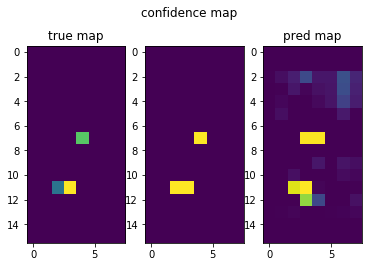

In [16]:
fig, axs= plt.subplots(1,3)
fig.suptitle('confidence map')
axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
axs[0].set_title('true map')
axs[1].imshow(y_true[0,:,:,2,0,4])
axs[2].set_title('pred map')
axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

In [17]:
y_true.shape

(1, 16, 8, 5, 6, 10)

In [19]:
def decode_netout(netout,  obj_thresh = 0.63, anchors=  anchors_list):
    input_shape = (16,8,5)
    original_input_shape = (512,128,40)
    
#     anchors = [[20, 45, 40], [20, 30, 40], [14, 40, 40], [20, 60, 40], [10, 40, 40], [30, 30, 40]]
    grid_h, grid_w,grid_d = netout.shape[1:4]
    num_boxes = len(anchors)
    netout = netout.reshape((grid_h, grid_w, grid_d,num_boxes, -1))
    nb_class = netout.shape[-1] - 5
    
    boxes = []

    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4]   = _sigmoid(netout[..., 4])
    
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
    netout[..., 5:] *= netout[..., 5:] > obj_thresh

    for row in range(grid_h):
        for col in range(grid_w):
            for dep in range(grid_d):
                for b in range(num_boxes):
                    objectness = netout[row, col,dep, b, 4]
                    
                    if(objectness <= obj_thresh): continue
                    
                    x, y, w, h = netout[row,col,dep,b,:4]
                    x = (row + x)*(original_input_shape[0]/input_shape[0]) 
                    y = (col + y)*(original_input_shape[1]/input_shape[1])
                    w = anchors[b][0] * np.exp(w) 
                    h = anchors[b][1] * np.exp(h)
                    classes = netout[row,col,dep,b,5:]

                    box_class = np.argmax(_softmax(classes))
                    
                    box = [x,y,w,h, objectness, box_class]
                    boxes.append(box)
    return boxes


In [20]:
# print(targets)
y_pred = model.predict(frame)
boxes = decode_netout(y_pred, 0.3)
pprint.pprint(boxes[:6])
len(boxes)

[[231.21512842178345,
  61.07785415649414,
  18.2568359375,
  48.475180864334106,
  0.9957716,
  0],
 [231.21212005615234,
  61.09937763214111,
  18.235633075237274,
  46.4681875705719,
  0.9955896,
  0],
 [231.1760549545288,
  61.14420700073242,
  18.836774863302708,
  48.15750062465668,
  0.9955017,
  0],
 [231.2807650566101,
  61.087839126586914,
  18.272769451141357,
  47.8955864906311,
  0.9957865,
  0],
 [231.2941436767578,
  61.10060501098633,
  18.32743138074875,
  49.18940216302872,
  0.99554706,
  0],
 [231.30813646316528,
  61.127296447753906,
  18.399682268500328,
  48.256346583366394,
  0.99563134,
  0]]


30

In [42]:

color_dict =  {0: 'r', 1:'g' , 2:'b'}
def visualise_bird_view(frame,targets, boxes, do_nms = False, do_photo = False, nms = False):
    fig, axs = plt.subplots(1,2, figsize = (10,10))
    
    im = np.sum(frame,axis = (0,3,4))
    
    if nms == True:
        boxes = do_nms_exp(boxes, 0.05)
        print(len(boxes))
    
    axs[0].imshow(im)
    axs[1].imshow(im)
    x_ticks = np.arange(0, im.shape[1], 20)
    y_ticks = np.arange(0, im.shape[0], 20)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)
    axs[0].set_title('target boxes')
    axs[1].set_title('predicted boxes')
    
    for num_target in range(targets.shape[1]):
        x = targets[0,num_target,2]
        y = targets[0,num_target,1]
        w = targets[0,num_target,4]
        h = targets[0,num_target,3]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)
        
    for box in boxes:
        x = box[1]
        y = box[0]
        w = box[3]
        h = box[2]
        class_box = box[5]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor= color_dict[class_box],facecolor='none')
#         rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[1].add_patch(rect)
        
    if do_photo:
        plt.savefig('comparison.png')

    
    

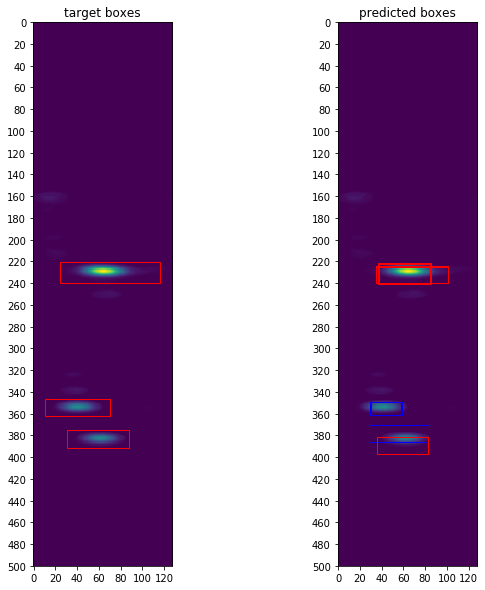

In [43]:
visualise_bird_view(frame, targets, boxes, nms = False, do_photo= False)

(1, 512, 128, 40, 1) (1, 20, 5) (1, 16, 8, 5, 6, 10)


<IPython.core.display.Javascript object>


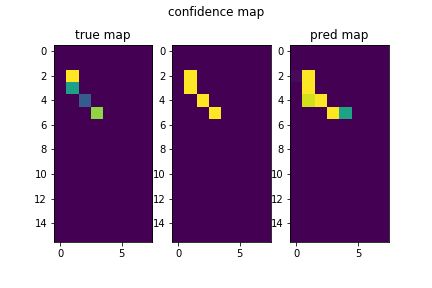

(0, 2, 1, 2, 0, 4)


/home/cognitive-comp/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


<IPython.core.display.Javascript object>


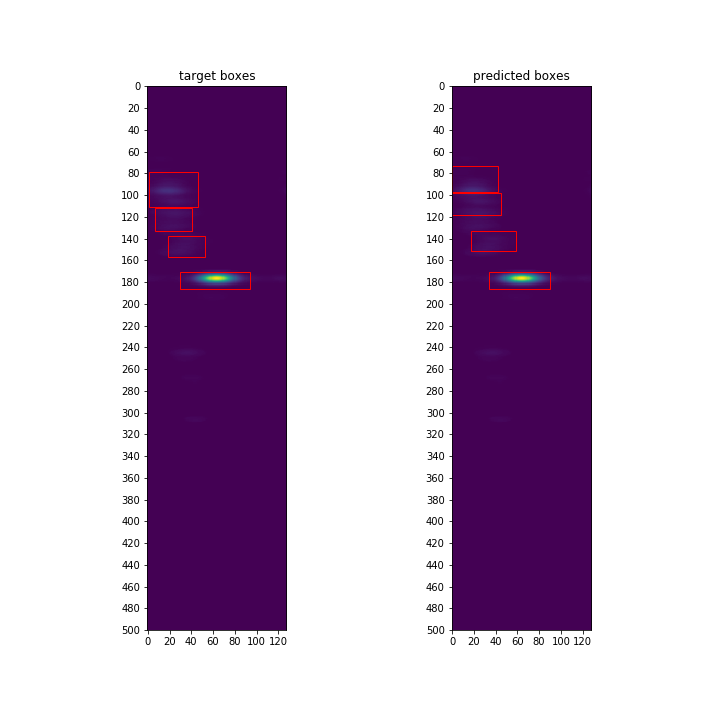

4


In [21]:
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/val_data/Data_30-May-2018 13-29-23_20.mat')
frame = matr['Matr'][15]
frame = frame[::2,::2,::2]
frame = np.reshape(frame,(1,512,128,40,1))
targets = abs(matr['Labels'][15])
targets = targets/2
targets = np.reshape(targets, newshape=(1, 20,5))
y_true =  preprocess_true_boxes(targets)
print(frame.shape,targets.shape,y_true.shape)

y_pred = model.predict(frame)

fig, axs= plt.subplots(1,3)
fig.suptitle('confidence map')
axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
axs[0].set_title('true map')
axs[1].imshow(y_true[0,:,:,2,0,4])
axs[2].set_title('pred map')
axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

print(np.unravel_index(y_true.argmax(),y_true.shape))
boxes = decode_netout(y_pred, 0.5)
visualise_bird_view(frame,targets,boxes, do_photo= False, nms = True)

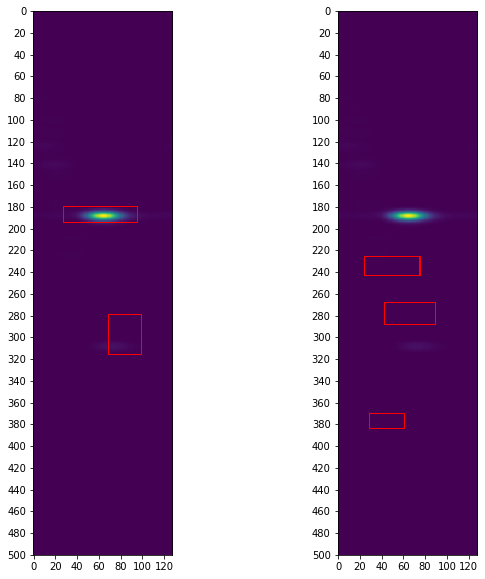

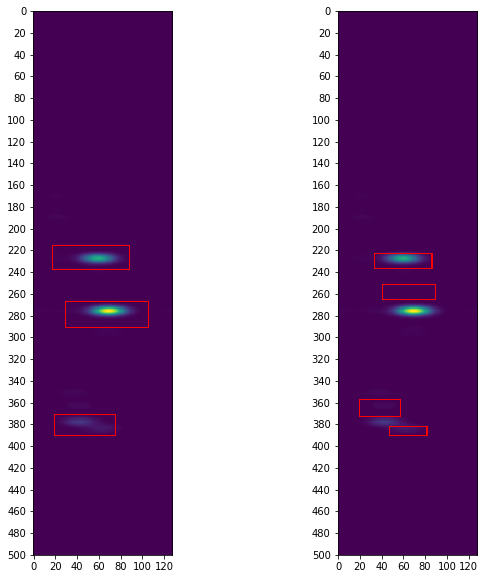

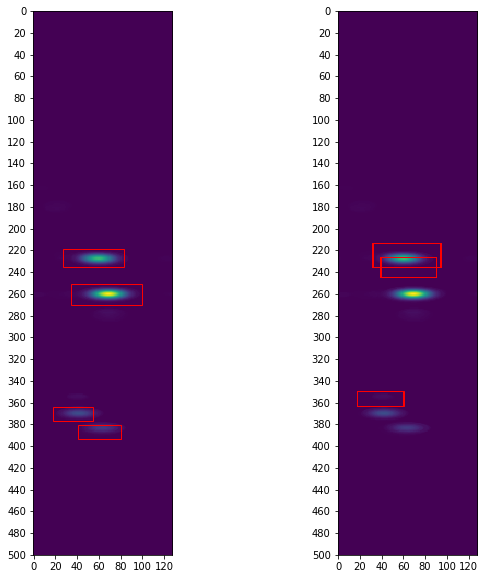

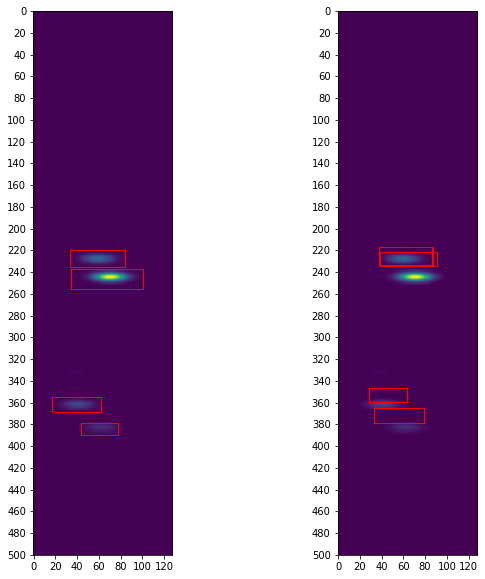

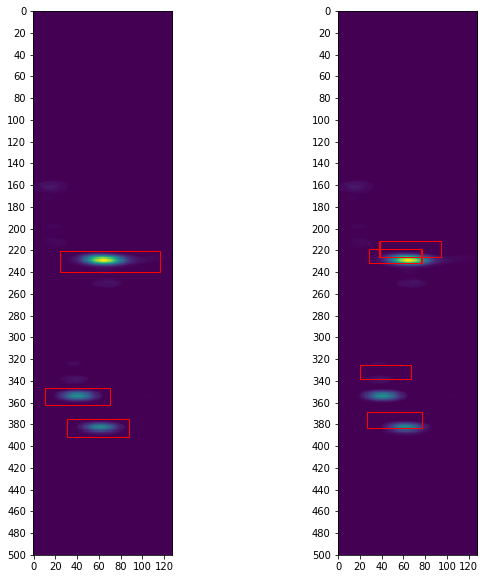

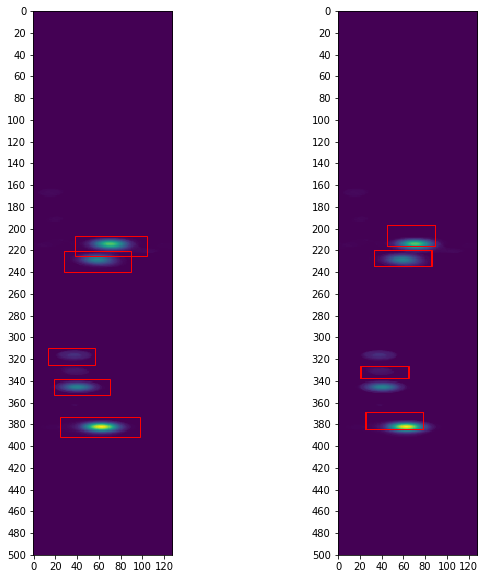

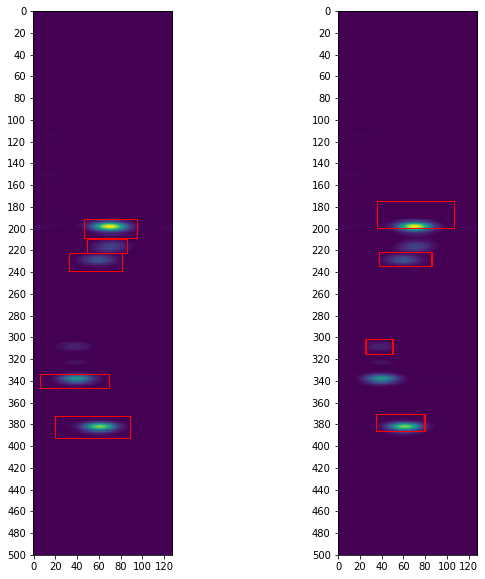

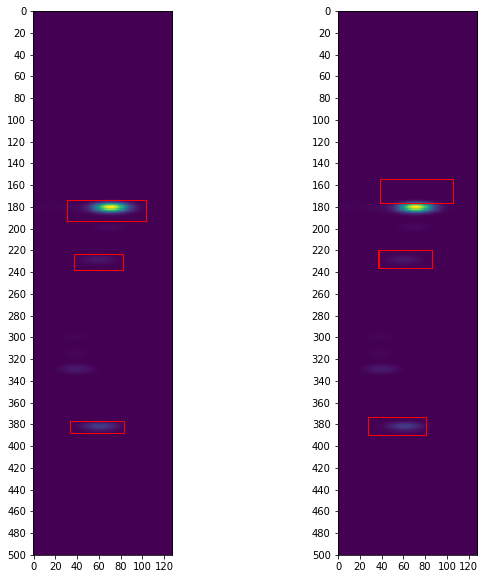

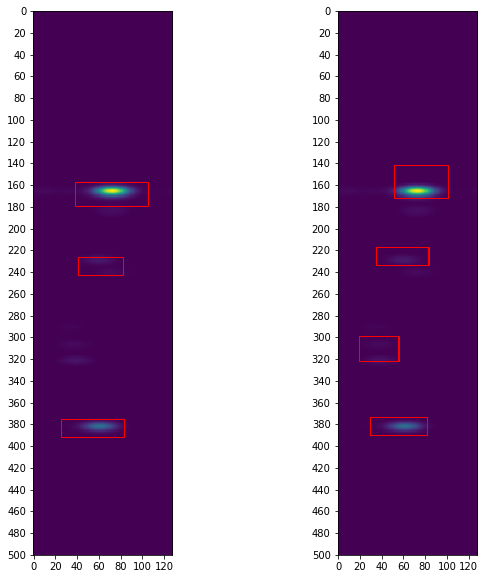

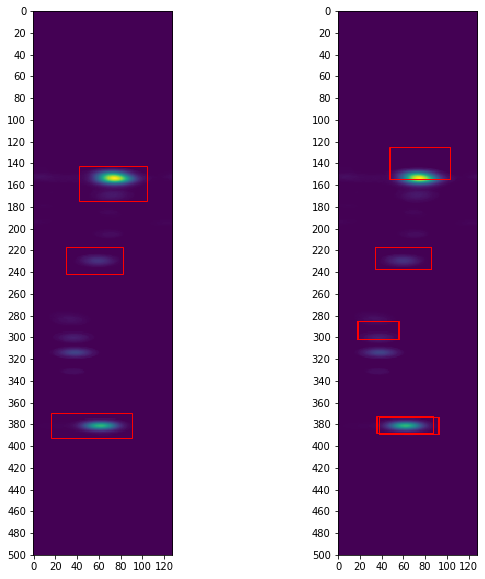

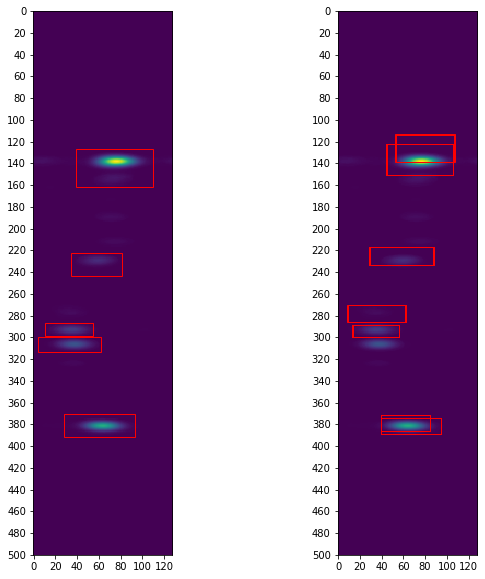

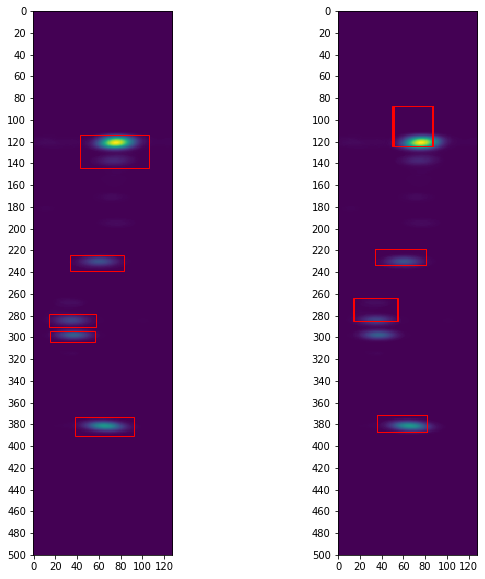

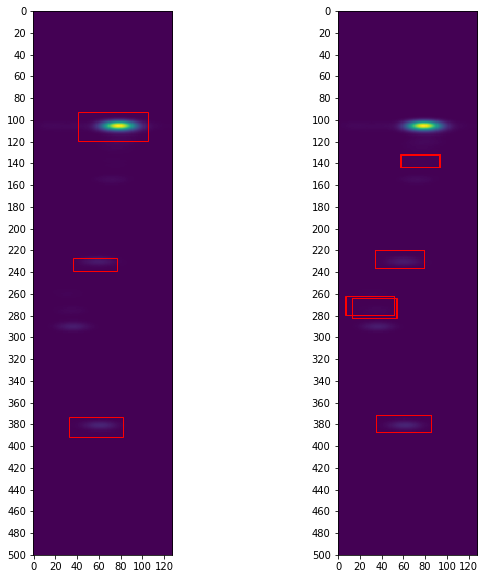

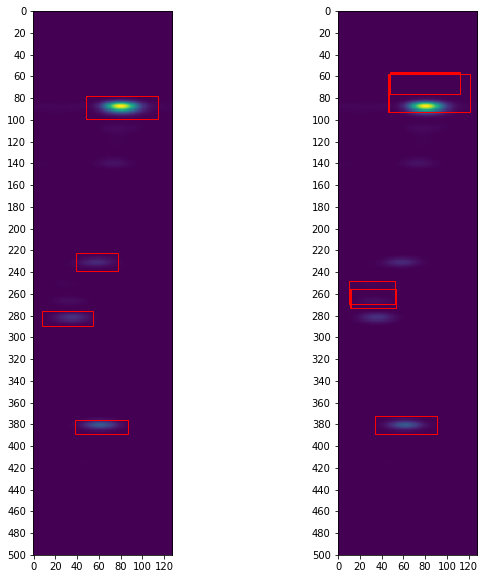

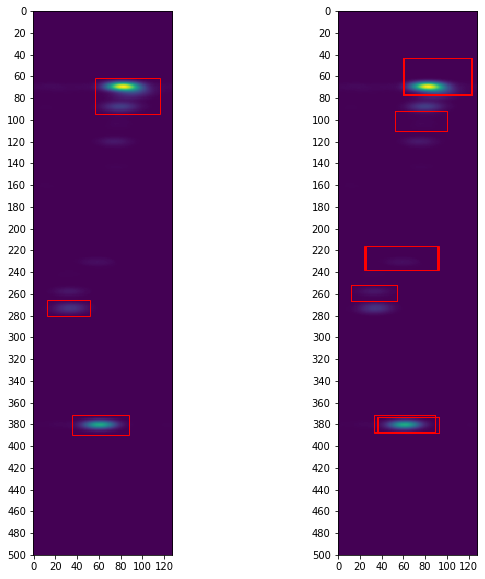

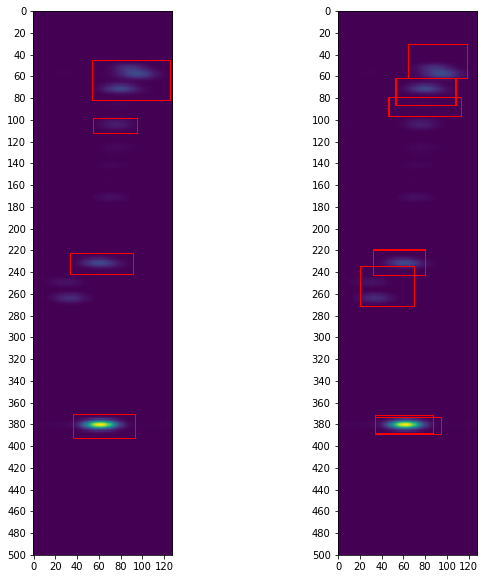

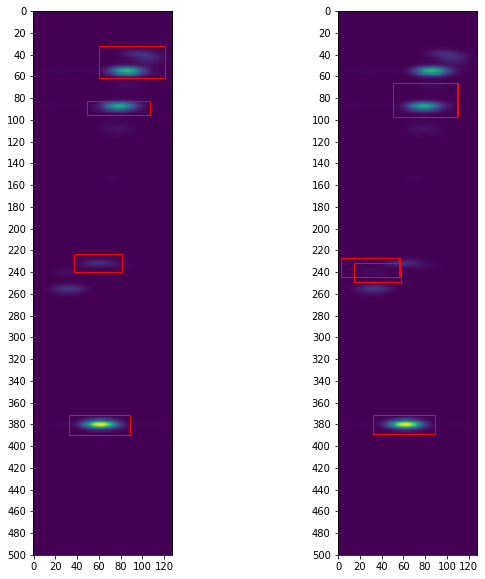

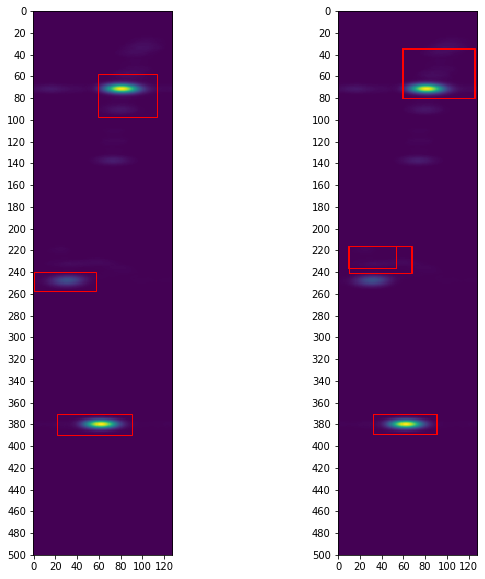

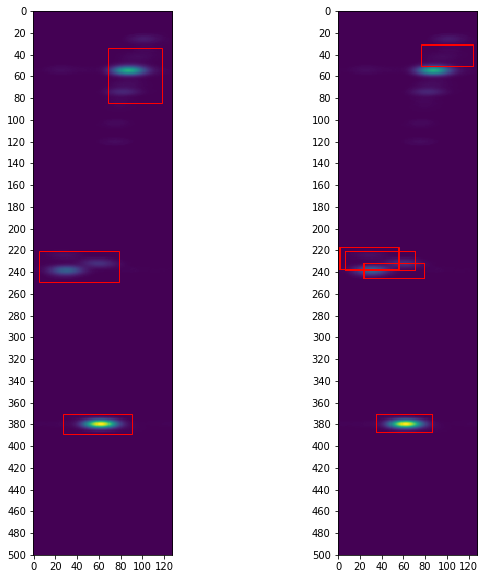

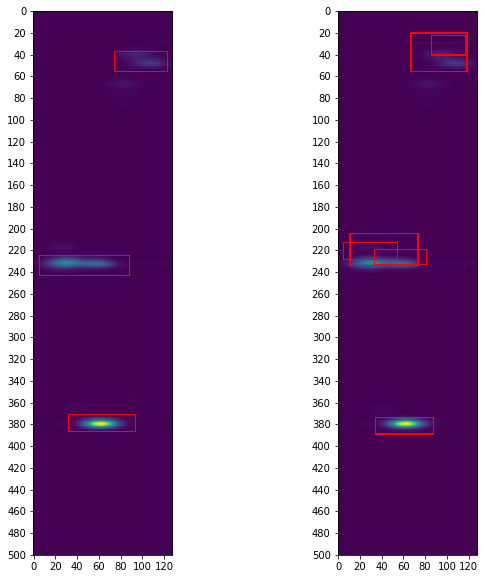

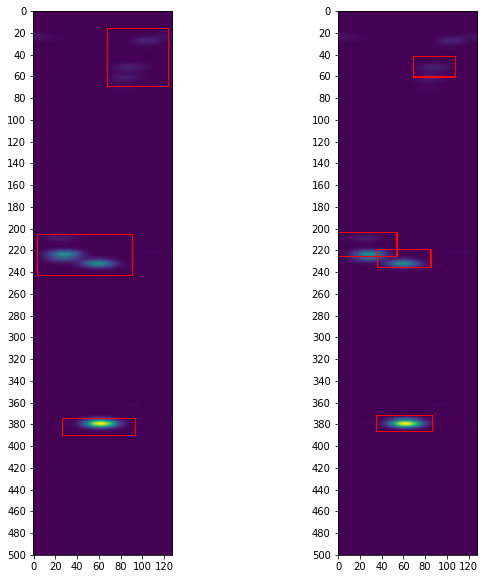

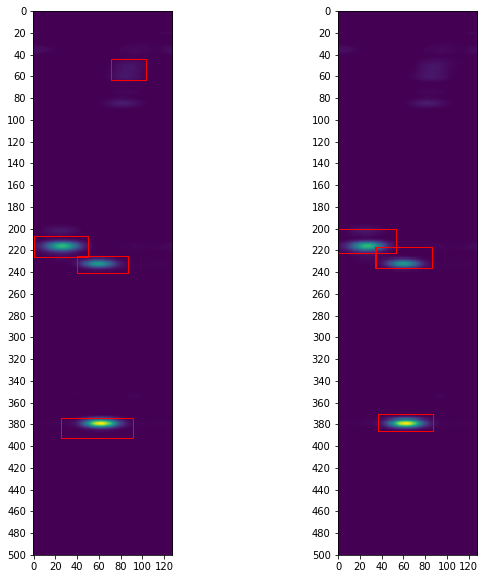

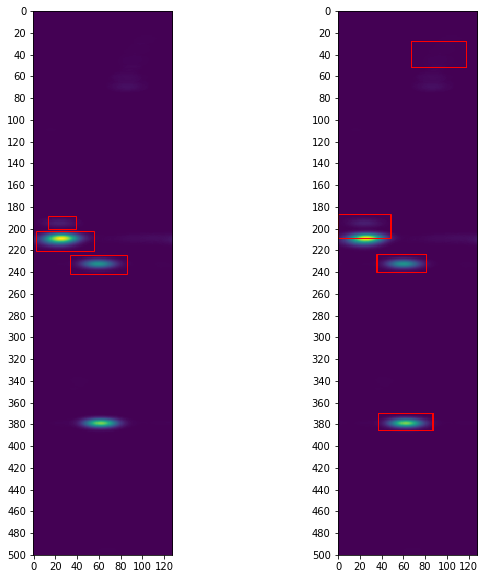

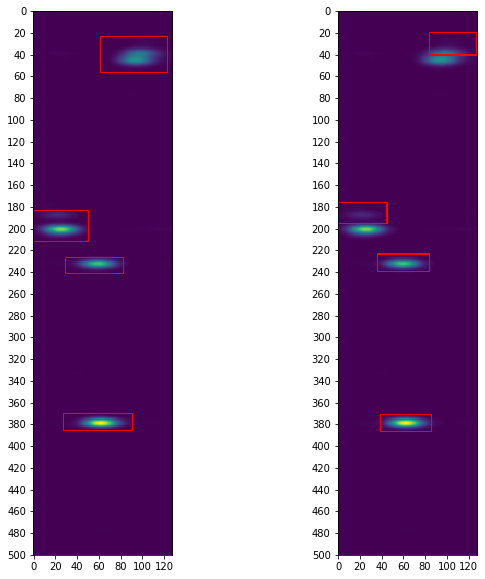

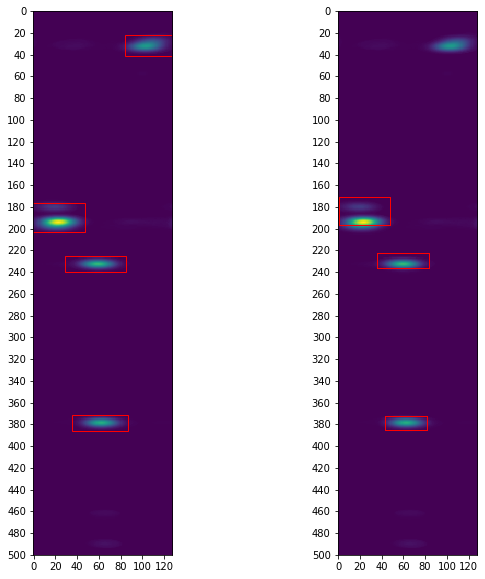

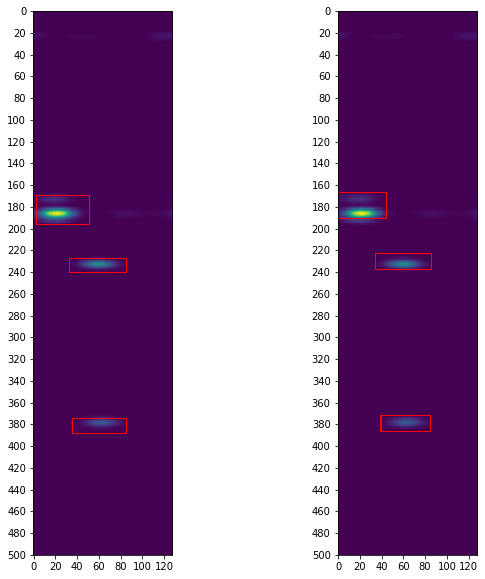

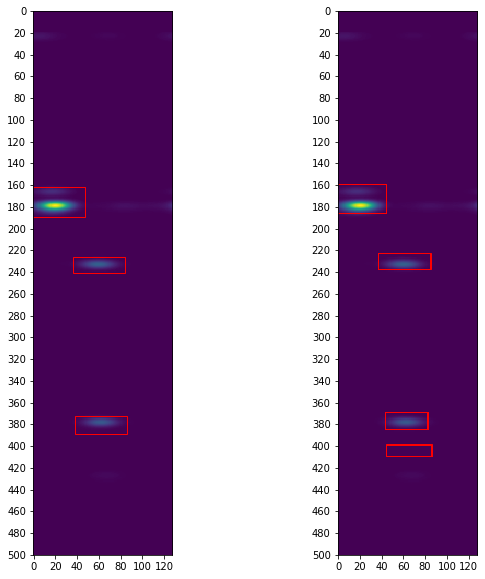

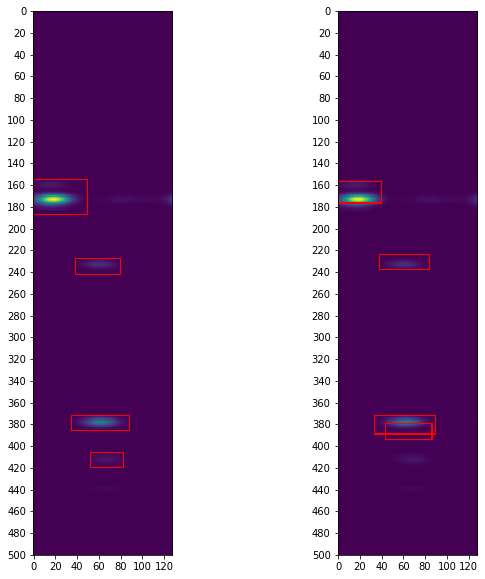

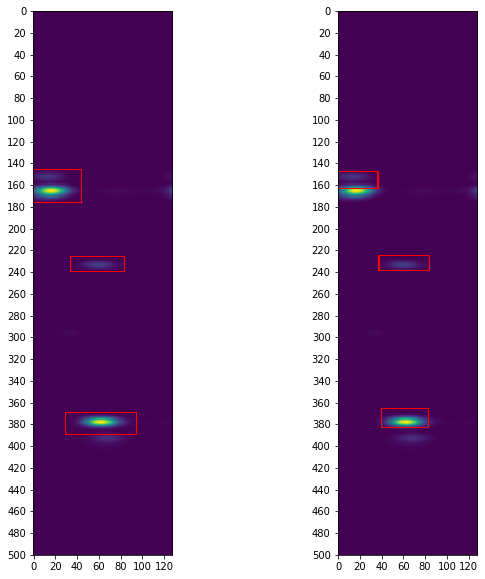

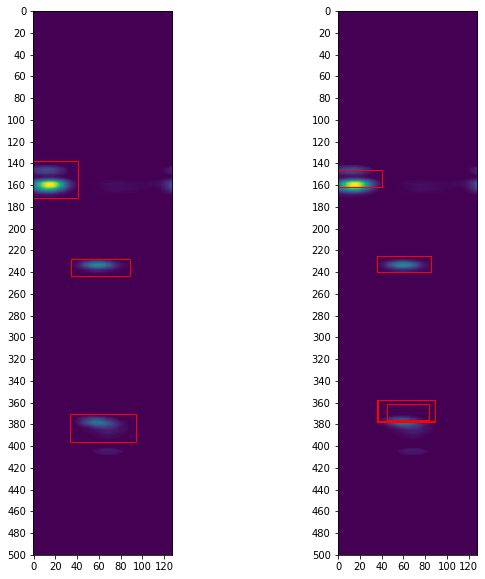

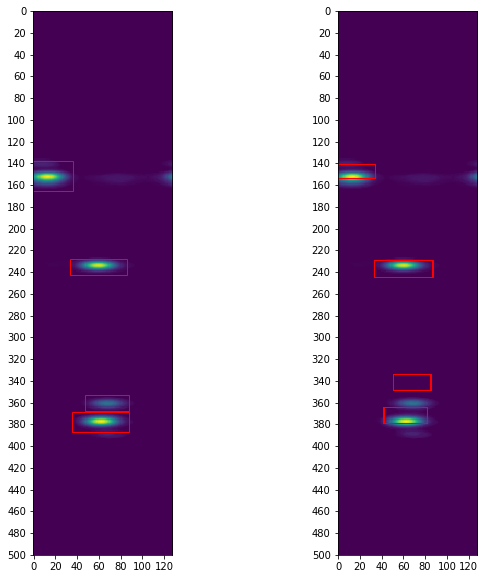

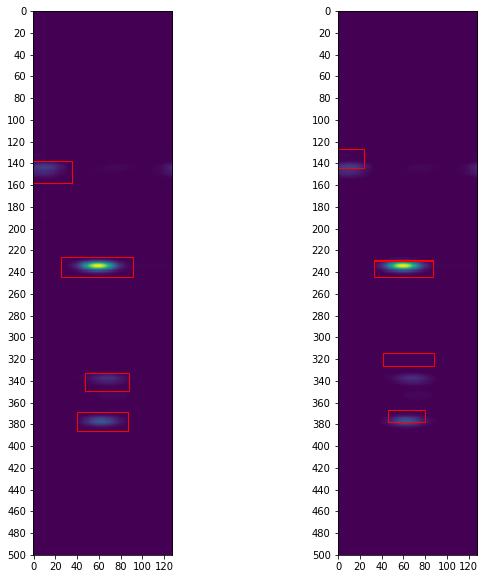

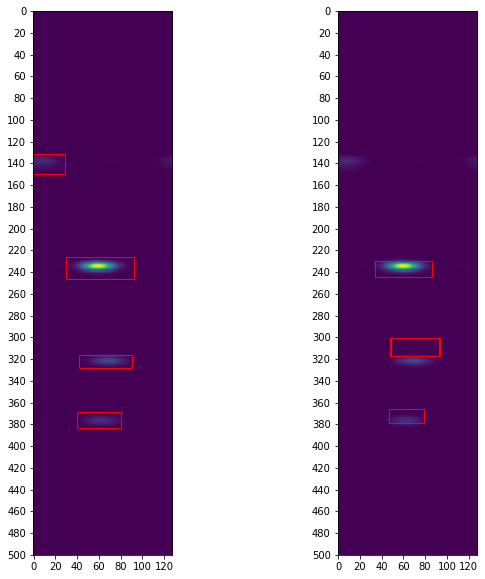

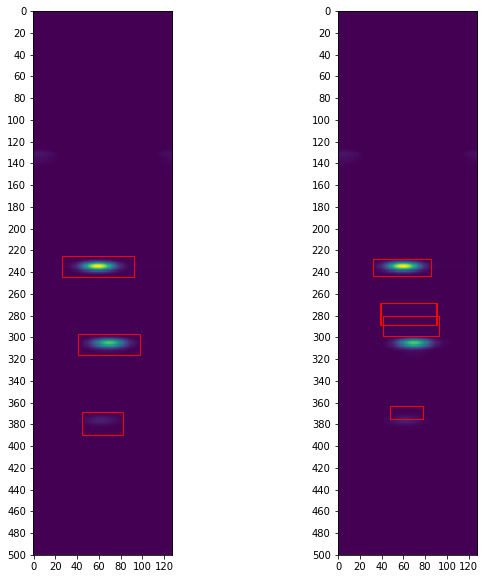

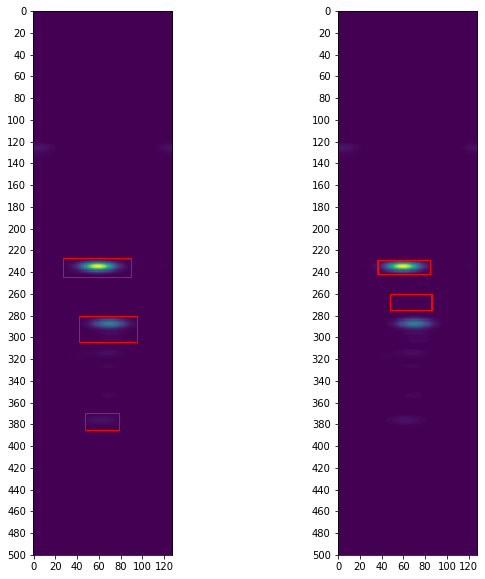

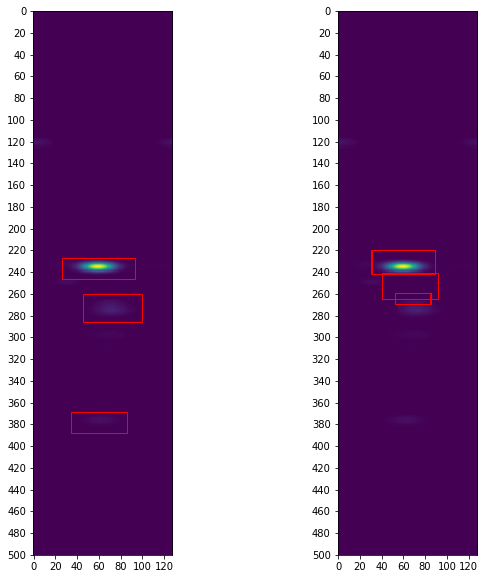

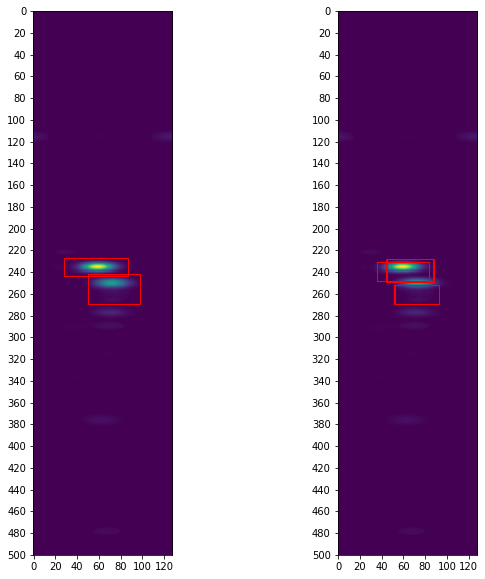

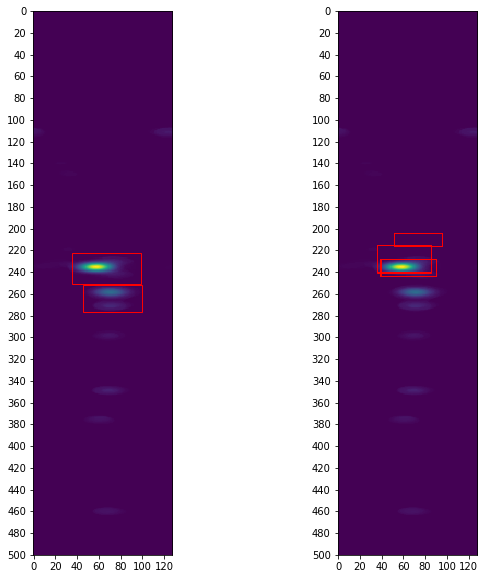

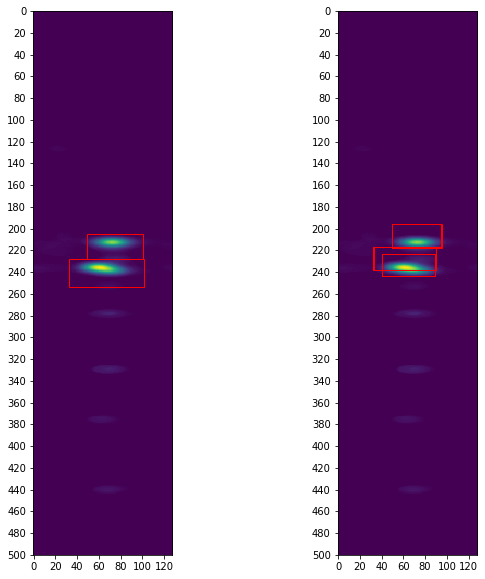

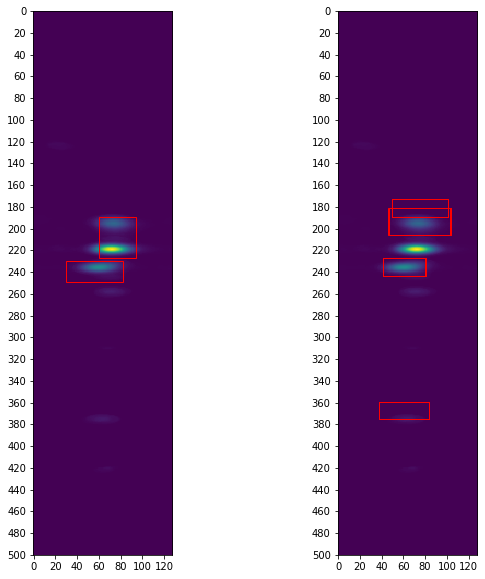

In [94]:
# matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/val_data/Data_30-May-2018 13-29-23_20.mat')
matr = scipy.io.loadmat('/home/cognitive-comp/Рабочий стол/projects/yolo/data/Data_30-May-2018 13-29-23_2.mat')

for num in range(len(matr['Matr'])):
    
    fig, axs = plt.subplots(1,2, figsize = (10,10))
    
    im = np.sum(frame,axis = (0,3,4))

    axs[0].imshow(im)
    axs[1].imshow(im)
    x_ticks = np.arange(0, im.shape[1], 20)
    y_ticks = np.arange(0, im.shape[0], 20)
    axs[0].set_xticks(x_ticks)
    axs[0].set_yticks(y_ticks)
    axs[1].set_xticks(x_ticks)
    axs[1].set_yticks(y_ticks)

    for num_target in range(targets.shape[1]):
        x = targets[0,num_target,2]
        y = targets[0,num_target,1]
        w = targets[0,num_target,4]
        h = targets[0,num_target,3]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[0].add_patch(rect)

# def one_frame(num):
    frame = matr['Matr'][num]
    frame = frame[::2,::2,::2]
    frame = np.reshape(frame,(1,512,128,40,1))
    targets = abs(matr['Labels'][num])
    targets = targets/2
    targets = np.reshape(targets, newshape=(1, 20,5))
    y_true =  preprocess_true_boxes(targets)
    # print(frame.shape,targets.shape,y_true.shape)

    y_pred = model.predict(frame)

#     fig, axs= plt.subplots(1,3)
#     fig.suptitle('confidence map')
#     axs[0].imshow(np.sum(y_true, axis = (0,3,4,5)))
#     axs[0].set_title('true map')
#     axs[1].imshow(y_true[0,:,:,2,0,4])
#     axs[2].set_title('pred map')
#     axs[2].imshow(_sigmoid(y_pred[0,:,:,2,0,4]))

#     print(np.unravel_index(y_true.argmax(),y_true.shape))

    boxes = decode_netout(y_pred, 0.5)
#     visualise_bird_view(frame,targets,boxes)

    for box in boxes:
        x = box[1]
        y = box[0]
        w = box[3]
        h = box[2]
        x_t = x-w/2
        x_b = x+w/2 
        y_t = y-h/2
        y_b = y+h/2
        rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
        axs[1].add_patch(rect)
    plt.show()
#     return mplfig_to_npimage(fig)


# x = np.linspace(-2, 2, 200)

# duration = 2

# # fig, ax = plt.subplots()
# def make_frame(t):
#     ax.clear()
#     ax.plot(x, np.sinc(x**2) + np.sin(x + 2*np.pi/duration * t), lw=3)
#     ax.set_ylim(-1.5, 2.5)
#     return mplfig_to_npimage(fig)

# # animation = VideoClip(make_frame, duration=duration)
# animation = VideoClip(one_frame, duration=duration)
# animation.ipython_display(fps=20, loop=True, autoplay=True)


In [259]:
#считает сколько различных классов есть и количество объектов по каждому классу
# pathname = os.path.abspath('data')
# class_dict = {}
# for file in glob.glob(pathname+'/*.mat'):
#     matr = scipy.io.loadmat(file)
#     for num_frame in range(len(matr['Labels'])):
#         Labels = np.array(matr["Labels"][num_frame])
# #         Labels = Labels/2
#         Labels[:,1:5] = Labels[:,1:5]/2
    
#         object_mask = Labels[Labels[:,0]>0,:]
#         if object_mask.shape[0] != 0:
# #             print(object_mask[])
#             for object_label in object_mask[:,0]:
# #                 print(object_label)
#                 if object_label in class_dict.keys():
#                     class_dict[object_label] += 1
#                 else:
#                     class_dict.setdefault(object_label, 1)

# print(class_dict)

{49.0: 1608, 53.0: 548, 52.0: 73, 51.0: 266, 50.0: 1}


In [102]:
# pathname = os.path.abspath('data')
# counter_frames = 0 
# counter_boxes = 0
# for file in glob.glob(pathname+'/*.mat'):
#     matr = scipy.io.loadmat(file)
#     for num_frame in range(len(matr['Labels'])):
#         Labels = np.array(matr["Labels"][num_frame])
# #         Labels = Labels/2
#         Labels[:,1:5] = Labels[:,1:5]/2
    
#         object_mask = Labels[Labels[:,0]>0,:]
#         if object_mask.shape[0] != 0:
#             counter_frames += 1
#             counter_boxes += object_mask.shape[0]
        
# print(counter_frames,counter_boxes)

# Visualisation

# Модель 2

In [12]:
def _sigmoid(x):
    return 1/(1 + np.exp(-x))

def _softmax(x, axis=-1):
    x = x - np.amax(x, axis, keepdims=True)
    e_x = np.exp(x)
    return e_x / e_x.sum(axis, keepdims=True)

def do_nms(boxes, nms_thresh):
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0
                    

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h, new_d = net_w, net_h , net_d
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
        
        
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union


def bbox_iou_norm_3d(box1,box2):
    box_intersect = Box()
    box_intersect.xmin = max(box1.xmin,box2.xmin)
    box_intersect.ymin = max(box1.ymin,box2.ymin)
    box_intersect.zmin = max(box1.zmin,box2.zmin)
    box_intersect.xmax = min(box1.xmax,box2.xmax)
    box_intersect.ymax = min(box1.ymax,box2.ymax)
    box_intersect.zmax = min(box1.zmax,box2.zmax)
    
    if box_intersect.xmin > box_intersect.xmax or box_intersect.ymin > box_intersect.ymax or box_intersect.zmin > box_intersect.zmax:
        intersect_vol = 0
    else:
        intersect_vol = box_intersect.get_vol()
    
    union_vol = box1.get_vol() + box2.get_vol() - intersect_vol 
    
    return intersect_vol/union_vol

def do_nms_exp(boxes, nms_thresh = 0.5):
    boxes = list(boxes)
    if len(boxes) ==  0:
        return
    sorted_indices = np.argsort([-box[4] for box in boxes])
    for i in range(len(sorted_indices)):
        index_i = sorted_indices[i]
        for j in range(i+1, len(sorted_indices)):
            index_j = sorted_indices[j]
            if boxes[index_j][0] == 0: continue
                
            if bbox_iou_exp(boxes[index_i], boxes[index_j]) >= nms_thresh:
                boxes[index_j] = [0,0,0,0,0]
    return [box for box in boxes if box[0] != 0]
                
def bbox_iou_exp(box1, box2):
    intersect_w = _interval_overlap([box1[0] - box1[2]/2 , box1[0]+ box1[2]/2 ], [box2[0] - box2[2]/2 , box2[0]+ box2[2]/2])
    intersect_h = _interval_overlap([box1[1] - box1[3]/2 , box1[1]+ box1[3]/2 ], [box2[1] - box2[3]/2 , box2[1]+ box2[3]/2])
#     print(intersect_h, intersect_w)
    intersect = intersect_w * intersect_h
    w1, h1 = box1[2], box1[3]
    w2, h2 = box2[2], box2[3]
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [228]:
boxes_copy = boxes
print(len(boxes_copy))
boxes_nms = do_nms_exp(boxes_copy,0.5)
# print(boxes_copy)
print(len(boxes_nms))

24
4


In [ ]:
# # код для чекания битых кадров

# pathname = os.path.abspath('data')
# for file in glob.glob(pathname+'/*.mat'):
#     matr = scipy.io.loadmat(file)
#     for num_frame in range(len(matr['Labels'])):
#         Labels = np.array(matr["Labels"][num_frame])
#         Labels = Labels/2
#         object_mask = Labels[:,0]
#         if object_mask.shape[0] != 0:
#             true_boxes = Labels[:,:]
#             targets = np.expand_dims(Labels,0)
#             frame = matr["Matr"][num_frame]
#             frame = frame[::2,::2,::2]
#             frame = np.reshape(frame,(1,frame.shape[0],frame.shape[1],frame.shape[2],1))
#             y_true = preprocess_true_boxes(targets)
#             print(file, num_frame,model.evaluate([frame,targets], y_true ))

In [23]:
import cv2

kernel = np.ones((7,7), np.uint8)

erosion = cv2.dilate(frame[0,...,0], kernel, iterations = 1)

In [24]:
erosion.shape

(512, 128, 40)

<IPython.core.display.Javascript object>


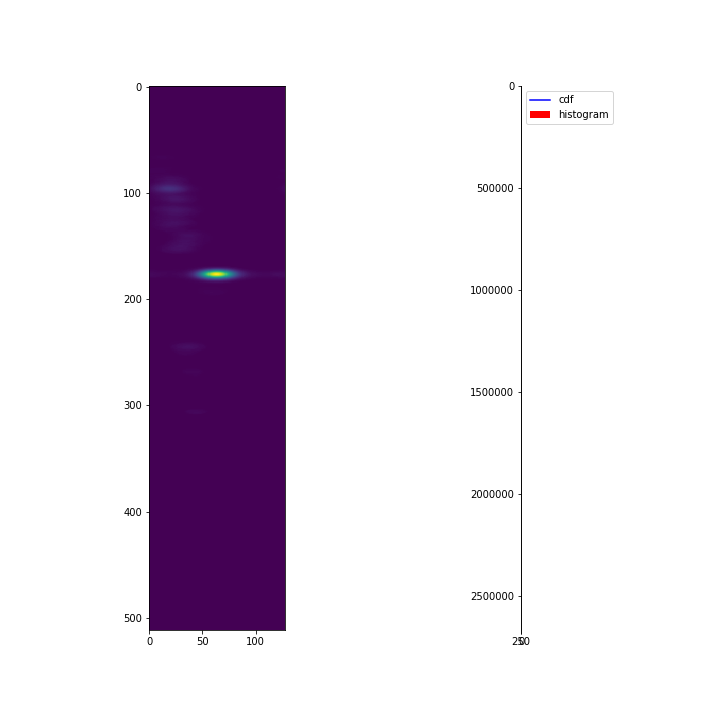

In [28]:
# plt.figure()
fig,axs = plt.subplots(1,2, figsize = (10,10))

axs[0].imshow(np.sum(frame[0,...,0],2))
axs[1].imshow(np.sum(erosion,2))
#     plt.imshow()

In [30]:
histogram_array = np.histogram(frame[0,...,0],bins = 256)
cdf = histogram_array[0].cumsum()
cdf_normalized = cdf*histogram_array[0].max()/cdf.max()


# print(histogram_array)

In [31]:
plt.plot(cdf_normalized, color = 'b')
plt.hist(frame.flatten(),256, color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

In [32]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [33]:
frame_equalised = cdf[frame[0,...,0]]

<IPython.core.display.Javascript object>


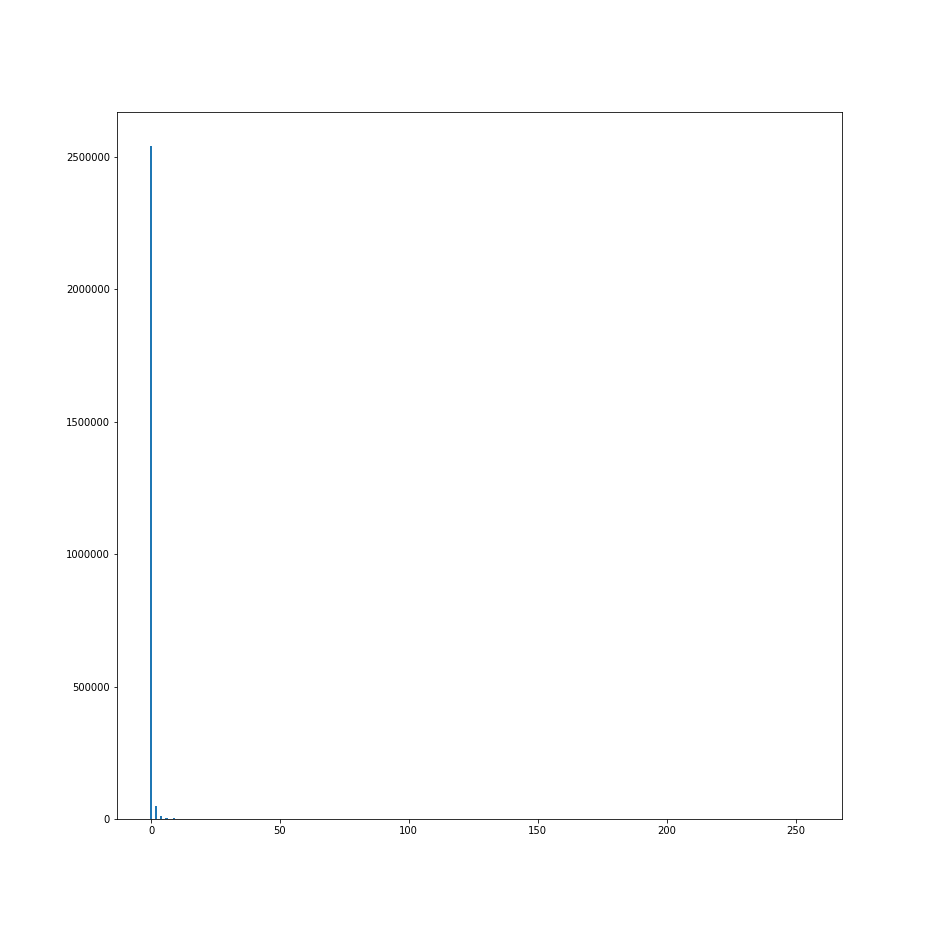

In [34]:
plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array[0])),histogram_array[0])
plt.show()

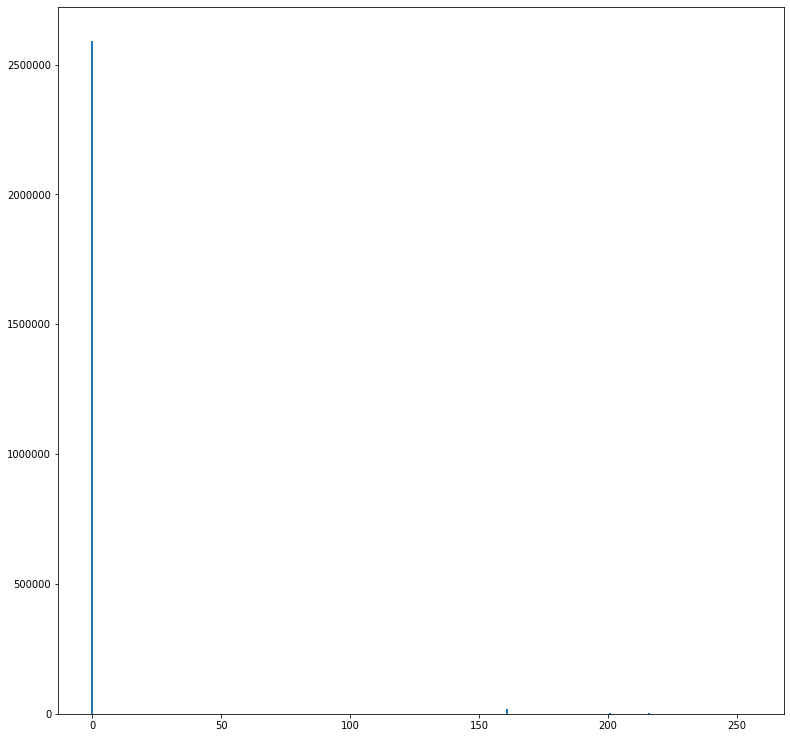

In [18]:
histogram_array_equalised = np.histogram(frame_equalised,bins = 256)
plt.figure(figsize = (13,13))
plt.bar(range(len(histogram_array_equalised[0])), histogram_array_equalised[0])
plt.show()

<IPython.core.display.Javascript object>


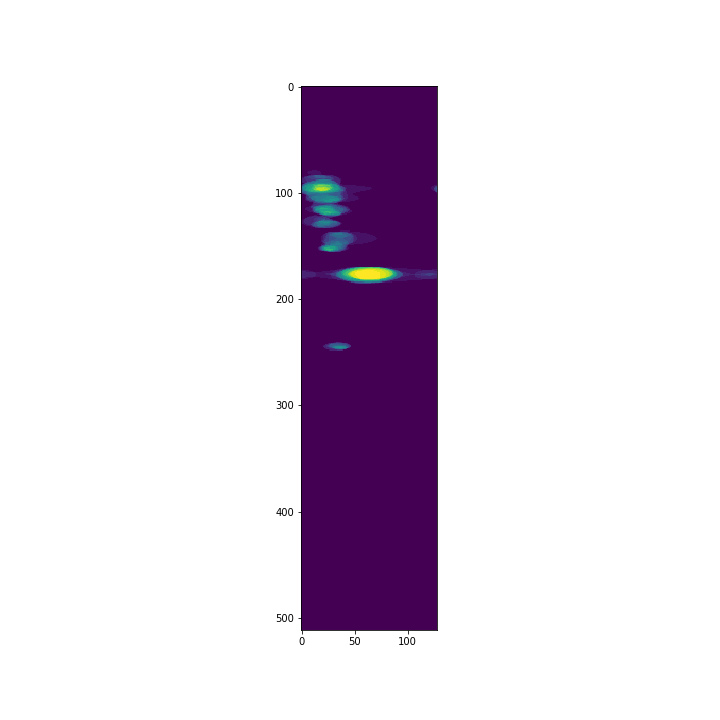

In [35]:
plt.figure(figsize = (10,10))
plt.imshow(np.sum(frame_equalised,2))
plt.show()

In [25]:
import cv2 as cv
import numpy as np

In [38]:
from skimage import data
from skimage import filters

val = filters.threshold_otsu(frame_equalised)
mask = frame_equalised > val

plt.imshow(np.sum(mask,2))

In [39]:
from skimage import measure
all_labels = measure.label(mask)

In [40]:
all_labels.shape

(512, 128, 40)

<IPython.core.display.Javascript object>


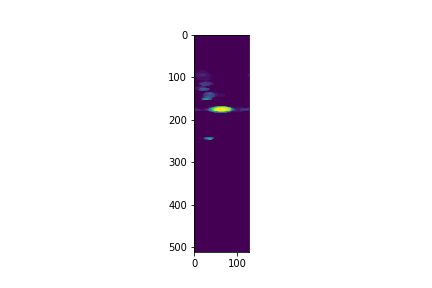

In [41]:
plt.figure()
plt.imshow(np.sum(all_labels,2))

In [42]:
all_labels.max()

13

In [43]:
blobs_labels = measure.label(mask)

In [44]:
blobs_labels.max()

13

In [56]:
from skimage.morphology import watershed
from skimage.feature import peak_local_max
import skimage


from scipy import ndimage
distance = ndimage.distance_transform_edt(frame_equalised)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3,3)), labels=frame_equalised)
markers = skimage.morphology.label(local_maxi)
labels_ws = watershed(-distance, markers, mask=frame_equalised)


In [57]:
labels_ws.shape

(512, 128, 40)

In [46]:
frame_equalised.shape

(512, 128, 40)

<IPython.core.display.Javascript object>


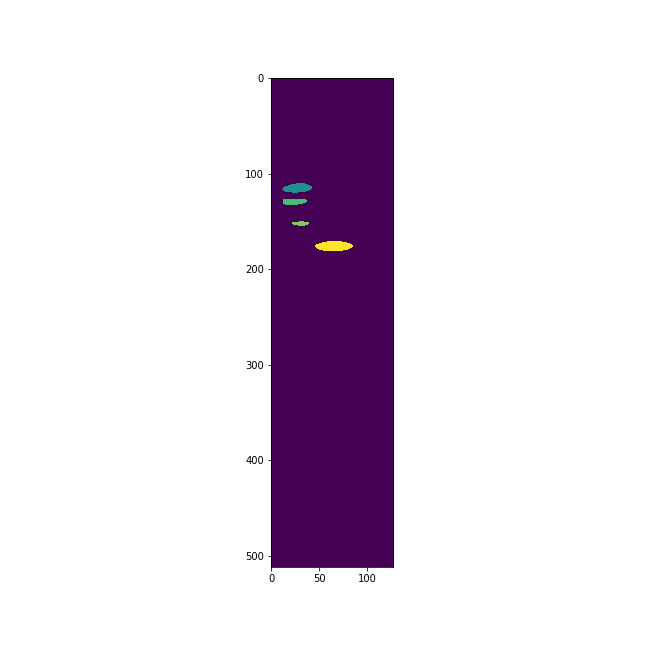

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [53]:
from ipywidgets import interact

# mask = mask.astype(np.int8)


def f(x):
    if x in list(range(all_labels.shape[-1])):
        plt.imshow(all_labels[...,x])
    return x

plt.figure(figsize = (9,9))
interact(f,x = (0, all_labels.shape[-1]-1))

<IPython.core.display.Javascript object>


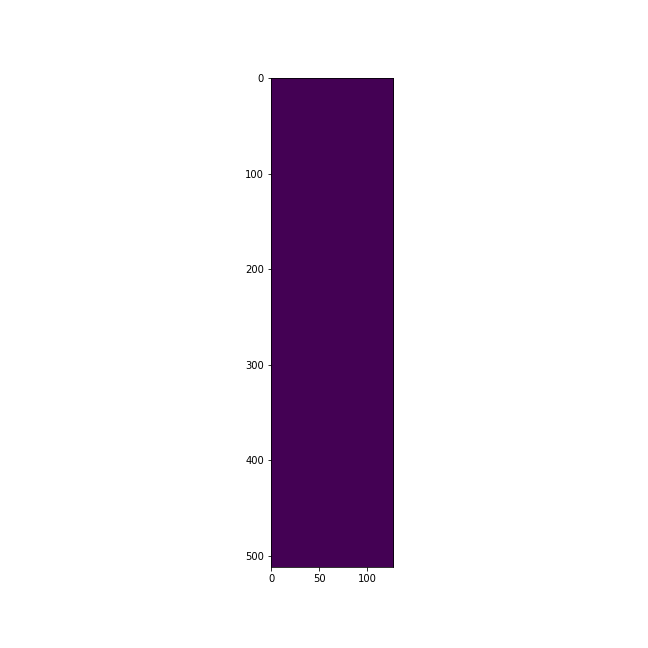

interactive(children=(IntSlider(value=19, description='x', max=39), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [58]:
def f(x):
    if x in list(range(labels_ws.shape[-1])):
        plt.imshow(labels_ws[...,x])
    return x

plt.figure(figsize = (9,9))
interact(f,x = (0, labels_ws.shape[-1]-1))

In [59]:
import scipy.ndimage

In [65]:
targets_generated = scipy.ndimage.find_objects(all_labels)

In [79]:
for i in targets_generated

[(slice(79, 123, None), slice(0, 67, None), slice(25, 40, None)),
 (slice(92, 99, None), slice(10, 30, None), slice(18, 23, None)),
 (slice(93, 100, None), slice(122, 128, None), slice(34, 36, None)),
 (slice(94, 101, None), slice(125, 128, None), slice(29, 33, None)),
 (slice(111, 125, None), slice(10, 46, None), slice(18, 26, None)),
 (slice(121, 133, None), slice(1, 30, None), slice(11, 14, None)),
 (slice(124, 134, None), slice(9, 39, None), slice(19, 28, None)),
 (slice(136, 156, None), slice(17, 72, None), slice(20, 38, None)),
 (slice(150, 156, None), slice(16, 35, None), slice(11, 16, None)),
 (slice(170, 186, None), slice(0, 128, None), slice(19, 40, None)),
 (slice(172, 182, None), slice(0, 14, None), slice(39, 40, None)),
 (slice(172, 182, None), slice(107, 128, None), slice(39, 40, None)),
 (slice(241, 249, None), slice(21, 47, None), slice(11, 22, None))]

In [97]:
N_DIM = 3
targets_matric = np.zeros((len(targets_generated), 2*N_DIM))

bounding_boxes = []
for ind in range(len(targets_generated)):
    item = targets_generated[ind]
    bounds = [(item[j].start,item[j].stop) for j in range(len(item))]
    print(bounds)
    bbox = []
    for dim in range(len(bounds)):
        start = bounds[dim][0]
        end = bounds[dim][1]
        center = (end + start)/2
        width = (end - start)
        bbox.append([center,width])
    print(bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1])
    bounding_boxes.append([bbox[0][0], bbox[1][0], bbox[2][0],bbox[0][1], bbox[1][1], bbox[2][1]])


[(79, 123), (0, 67), (25, 40)]
101.0 33.5 32.5 44 67 15
[(92, 99), (10, 30), (18, 23)]
95.5 20.0 20.5 7 20 5
[(93, 100), (122, 128), (34, 36)]
96.5 125.0 35.0 7 6 2
[(94, 101), (125, 128), (29, 33)]
97.5 126.5 31.0 7 3 4
[(111, 125), (10, 46), (18, 26)]
118.0 28.0 22.0 14 36 8
[(121, 133), (1, 30), (11, 14)]
127.0 15.5 12.5 12 29 3
[(124, 134), (9, 39), (19, 28)]
129.0 24.0 23.5 10 30 9
[(136, 156), (17, 72), (20, 38)]
146.0 44.5 29.0 20 55 18
[(150, 156), (16, 35), (11, 16)]
153.0 25.5 13.5 6 19 5
[(170, 186), (0, 128), (19, 40)]
178.0 64.0 29.5 16 128 21
[(172, 182), (0, 14), (39, 40)]
177.0 7.0 39.5 10 14 1
[(172, 182), (107, 128), (39, 40)]
177.0 117.5 39.5 10 21 1
[(241, 249), (21, 47), (11, 22)]
245.0 34.0 16.5 8 26 11


In [98]:
np.array(bounding_boxes)

array([[101. ,  33.5,  32.5,  44. ,  67. ,  15. ],
       [ 95.5,  20. ,  20.5,   7. ,  20. ,   5. ],
       [ 96.5, 125. ,  35. ,   7. ,   6. ,   2. ],
       [ 97.5, 126.5,  31. ,   7. ,   3. ,   4. ],
       [118. ,  28. ,  22. ,  14. ,  36. ,   8. ],
       [127. ,  15.5,  12.5,  12. ,  29. ,   3. ],
       [129. ,  24. ,  23.5,  10. ,  30. ,   9. ],
       [146. ,  44.5,  29. ,  20. ,  55. ,  18. ],
       [153. ,  25.5,  13.5,   6. ,  19. ,   5. ],
       [178. ,  64. ,  29.5,  16. , 128. ,  21. ],
       [177. ,   7. ,  39.5,  10. ,  14. ,   1. ],
       [177. , 117.5,  39.5,  10. ,  21. ,   1. ],
       [245. ,  34. ,  16.5,   8. ,  26. ,  11. ]])

<IPython.core.display.Javascript object>


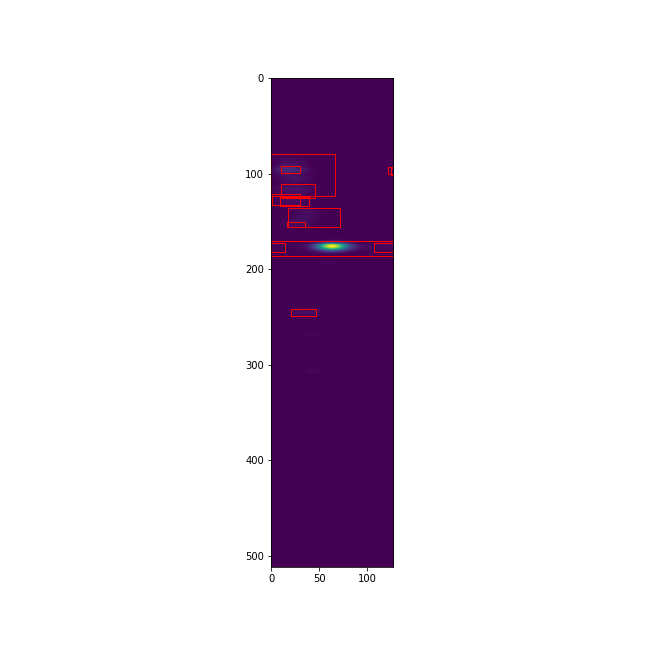

[101.0, 33.5, 32.5, 44, 67, 15]
[95.5, 20.0, 20.5, 7, 20, 5]
[96.5, 125.0, 35.0, 7, 6, 2]
[97.5, 126.5, 31.0, 7, 3, 4]
[118.0, 28.0, 22.0, 14, 36, 8]
[127.0, 15.5, 12.5, 12, 29, 3]
[129.0, 24.0, 23.5, 10, 30, 9]
[146.0, 44.5, 29.0, 20, 55, 18]
[153.0, 25.5, 13.5, 6, 19, 5]
[178.0, 64.0, 29.5, 16, 128, 21]
[177.0, 7.0, 39.5, 10, 14, 1]
[177.0, 117.5, 39.5, 10, 21, 1]
[245.0, 34.0, 16.5, 8, 26, 11]


In [99]:
im = np.sum(frame,axis = (0,3,4))

fig,ax = plt.subplots(1, figsize = (9,9))

# Display the image
ax.imshow(im)

plt.show()


for box in bounding_boxes:
    x = box[1]
    y = box[0]
    w = box[4]
    h = box[3]
    print(box)
    x_t = x-w/2
    x_b = x+w/2 
    y_t = y-h/2
    y_b = y+h/2
    rect = patches.Rectangle((x_t,y_t),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

In [102]:
%%time
points_cord = []
for i in range(frame_equalised.shape[0]):
    for j in range(frame_equalised.shape[1]):
        for k in range(frame_equalised.shape[2]):
            if frame_equalised[i,j,k] > 0:
                points_cord.append([i,j,k,frame_equalised[i,j,k]])

points_cord = np.array(points_cord)

CPU times: user 3.46 s, sys: 2.08 ms, total: 3.47 s
Wall time: 3.46 s


In [105]:
import pptk
v = pptk.viewer(points_cord)

KeyboardInterrupt: 

In [110]:
import open3d

open3d.visualization.draw_geometries(points_cord) # Visualize the point cloud     

TypeError: draw_geometries(): incompatible function arguments. The following argument types are supported:
    1. (geometry_list: List[open3d.open3d.geometry.Geometry], window_name: str = 'Open3D', width: int = 1920, height: int = 1080, left: int = 50, top: int = 50) -> None

Invoked with: array([[ 79,  10,  34,   1],
       [ 79,  11,  34,   1],
       [ 79,  12,  34,   1],
       ...,
       [248,  38,  19,   1],
       [248,  39,  11,   1],
       [248,  39,  12,   1]])

In [115]:
import copy
import numpy as np
import open3d as o3d



# generate some neat n times 3 matrix using a variant of sync function
x = np.linspace(-3, 3, 401)
mesh_x, mesh_y = np.meshgrid(x, x)
z = np.sinc((np.power(mesh_x, 2) + np.power(mesh_y, 2)))
z_norm = (z - z.min()) / (z.max() - z.min())
xyz = np.zeros((np.size(mesh_x), 3))
xyz[:, 0] = np.reshape(mesh_x, -1)
xyz[:, 1] = np.reshape(mesh_y, -1)
xyz[:, 2] = np.reshape(z_norm, -1)
print('xyz')
print(xyz)

# Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
o3d.io.write_point_cloud("../../TestData/sync.ply", pcd)

# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("../../TestData/sync.ply")
o3d.visualization.draw_geometries([pcd_load])

# convert Open3D.o3d.geometry.PointCloud to numpy array
xyz_load = np.asarray(pcd_load.points)
print('xyz_load')
print(xyz_load)

# save z_norm as an image (change [0,1] range to [0,255] range with uint8 type)
img = o3d.geometry.Image((z_norm * 255).astype(np.uint8))
o3d.io.write_image("../../TestData/sync.png", img)
o3d.visualization.draw_geometries([img])

xyz
[[-3.         -3.          0.17846472]
 [-2.985      -3.          0.17440115]
 [-2.97       -3.          0.17063709]
 ...
 [ 2.97        3.          0.17063709]
 [ 2.985       3.          0.17440115]
 [ 3.          3.          0.17846472]]
xyz_load
[]


In [114]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_cord)
o3d.io.write_point_cloud("../../TestData/sync.ply", pcd)

# Load saved point cloud and visualize it
pcd_load = o3d.io.read_point_cloud("../../TestData/sync.ply")
o3d.visualization.draw_geometries([pcd_load])


RuntimeError: Unable to cast Python instance to C++ type (compile in debug mode for details)